# FITZPATRICK

In [1]:
pwd

'/Users/charles.lu/AAAI/AAAI-22/src'

In [454]:
(df.subgroup == 6).sum() / len(df)

0.038523598225090765

In [2]:
import platt
import uncertainty
import conformal
import distances
import metrics
import utils

import importlib
importlib.reload(metrics)
importlib.reload(platt)
importlib.reload(uncertainty)
importlib.reload(conformal)
importlib.reload(utils)
importlib.reload(distances)
from utils import first

import collections, itertools, json, os, pathlib, sys

import PIL
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('bmh')
import torch
print('scipy\t', scipy.__version__)
print('pytorch\t', torch.__version__)
print('pandas\t', pd.__version__)
print('numpy\t', np.__version__)
print('python\t', sys.version)
np.random.seed(0)

scipy	 1.7.3
pytorch	 1.10.2
pandas	 1.4.0
numpy	 1.22.1
python	 3.9.9 (main, Jan 13 2022, 10:56:10) 
[Clang 12.0.0 (clang-1200.0.32.28)]


## Path to label file

In [3]:
label_csv = '/Users/charles.lu/AAAI/data/skin/skin-info.csv'
skin_df = pd.read_csv(label_csv)

## Save figures here

In [4]:
save_dir = pathlib.Path('/Users/charles.lu/AAAI/')
fig_dir = save_dir / 'figures'
fig_dir.mkdir(exist_ok=True)

## Class distriubtion 

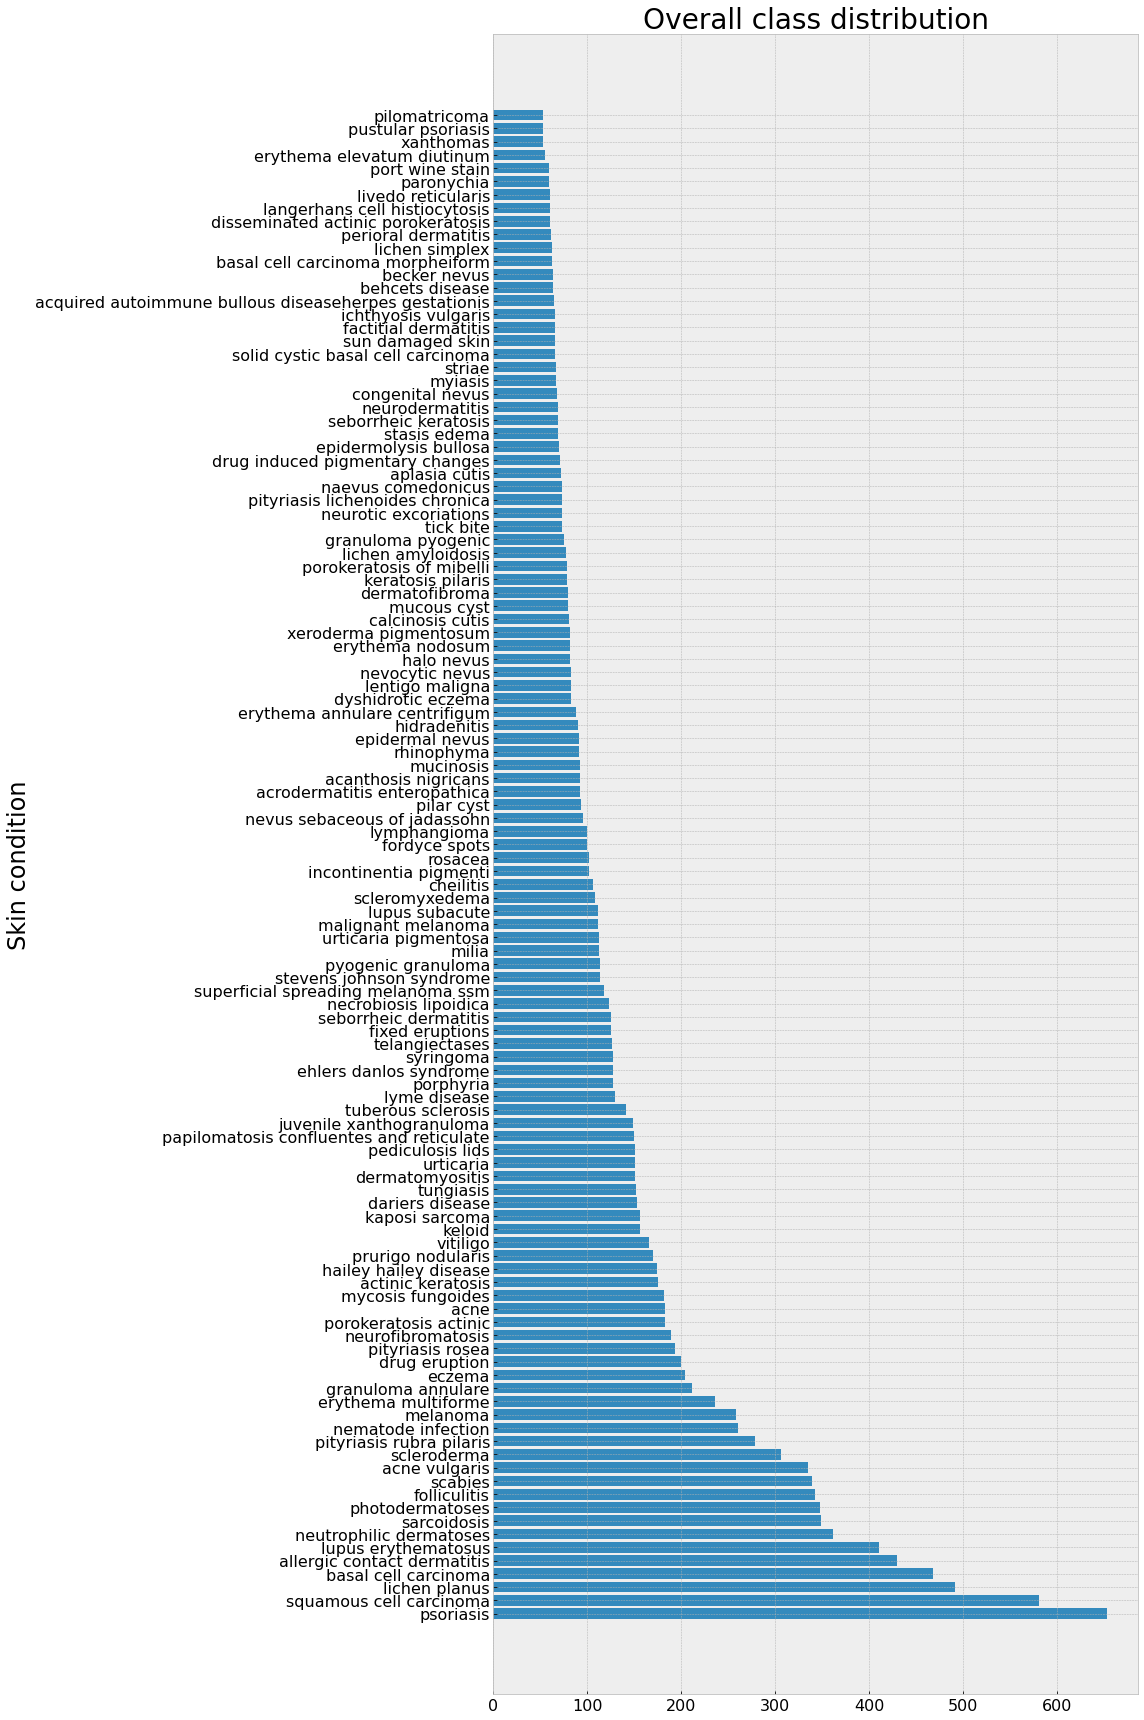

In [5]:
plt.figure(figsize=(16, 24))
plt.title('Overall class distribution', fontsize=28)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Skin condition', fontsize=24)
plt.barh(*list(zip(*skin_df.raw_label.value_counts().items())))
plt.tight_layout()
plt.savefig(fig_dir / 'fitz-class-dist.png')
plt.show()

In [6]:
class_dict_114 = {'acanthosis nigricans': 0, 'acne': 1, 'acne vulgaris': 2, 'acquired autoimmune bullous diseaseherpes gestationis': 3, 'acrodermatitis enteropathica': 4, 'actinic keratosis': 5, 'allergic contact dermatitis': 6, 'aplasia cutis': 7, 'basal cell carcinoma': 8, 'basal cell carcinoma morpheiform': 9, 'becker nevus': 10, 'behcets disease': 11, 'calcinosis cutis': 12, 'cheilitis': 13, 'congenital nevus': 14, 'dariers disease': 15, 'dermatofibroma': 16, 'dermatomyositis': 17, 'disseminated actinic porokeratosis': 18, 'drug eruption': 19, 'drug induced pigmentary changes': 20, 'dyshidrotic eczema': 21, 'eczema': 22, 'ehlers danlos syndrome': 23, 'epidermal nevus': 24, 'epidermolysis bullosa': 25, 'erythema annulare centrifigum': 26, 'erythema elevatum diutinum': 27, 'erythema multiforme': 28, 'erythema nodosum': 29, 'factitial dermatitis': 30, 'fixed eruptions': 31, 'folliculitis': 32, 'fordyce spots': 33, 'granuloma annulare': 34, 'granuloma pyogenic': 35, 'hailey hailey disease': 36, 'halo nevus': 37, 'hidradenitis': 38, 'ichthyosis vulgaris': 39, 'incontinentia pigmenti': 40, 'juvenile xanthogranuloma': 41, 'kaposi sarcoma': 42, 'keloid': 43, 'keratosis pilaris': 44, 'langerhans cell histiocytosis': 45, 'lentigo maligna': 46, 'lichen amyloidosis': 47, 'lichen planus': 48, 'lichen simplex': 49, 'livedo reticularis': 50, 'lupus erythematosus': 51, 'lupus subacute': 52, 'lyme disease': 53, 'lymphangioma': 54, 'malignant melanoma': 55, 'melanoma': 56, 'milia': 57, 'mucinosis': 58, 'mucous cyst': 59, 'mycosis fungoides': 60, 'myiasis': 61, 'naevus comedonicus': 62, 'necrobiosis lipoidica': 63, 'nematode infection': 64, 'neurodermatitis': 65, 'neurofibromatosis': 66, 'neurotic excoriations': 67, 'neutrophilic dermatoses': 68, 'nevocytic nevus': 69, 'nevus sebaceous of jadassohn': 70, 'papilomatosis confluentes and reticulate': 71, 'paronychia': 72, 'pediculosis lids': 73, 'perioral dermatitis': 74, 'photodermatoses': 75, 'pilar cyst': 76, 'pilomatricoma': 77, 'pityriasis lichenoides chronica': 78, 'pityriasis rosea': 79, 'pityriasis rubra pilaris': 80, 'porokeratosis actinic': 81, 'porokeratosis of mibelli': 82, 'porphyria': 83, 'port wine stain': 84, 'prurigo nodularis': 85, 'psoriasis': 86, 'pustular psoriasis': 87, 'pyogenic granuloma': 88, 'rhinophyma': 89, 'rosacea': 90, 'sarcoidosis': 91, 'scabies': 92, 'scleroderma': 93, 'scleromyxedema': 94, 'seborrheic dermatitis': 95, 'seborrheic keratosis': 96, 'solid cystic basal cell carcinoma': 97, 'squamous cell carcinoma': 98, 'stasis edema': 99, 'stevens johnson syndrome': 100, 'striae': 101, 'sun damaged skin': 102, 'superficial spreading melanoma ssm': 103, 'syringoma': 104, 'telangiectases': 105, 'tick bite': 106, 'tuberous sclerosis': 107, 'tungiasis': 108, 'urticaria': 109, 'urticaria pigmentosa': 110, 'vitiligo': 111, 'xanthomas': 112, 'xeroderma pigmentosum': 113}
class_dict_9 = {'benign dermal': 0, 'benign epidermal': 1, 'benign melanocyte': 2, 'genodermatoses': 3, 'inflammatory': 4, 'malignant cutaneous lymphoma': 5, 'malignant dermal': 6, 'malignant epidermal': 7, 'malignant melanoma': 8}

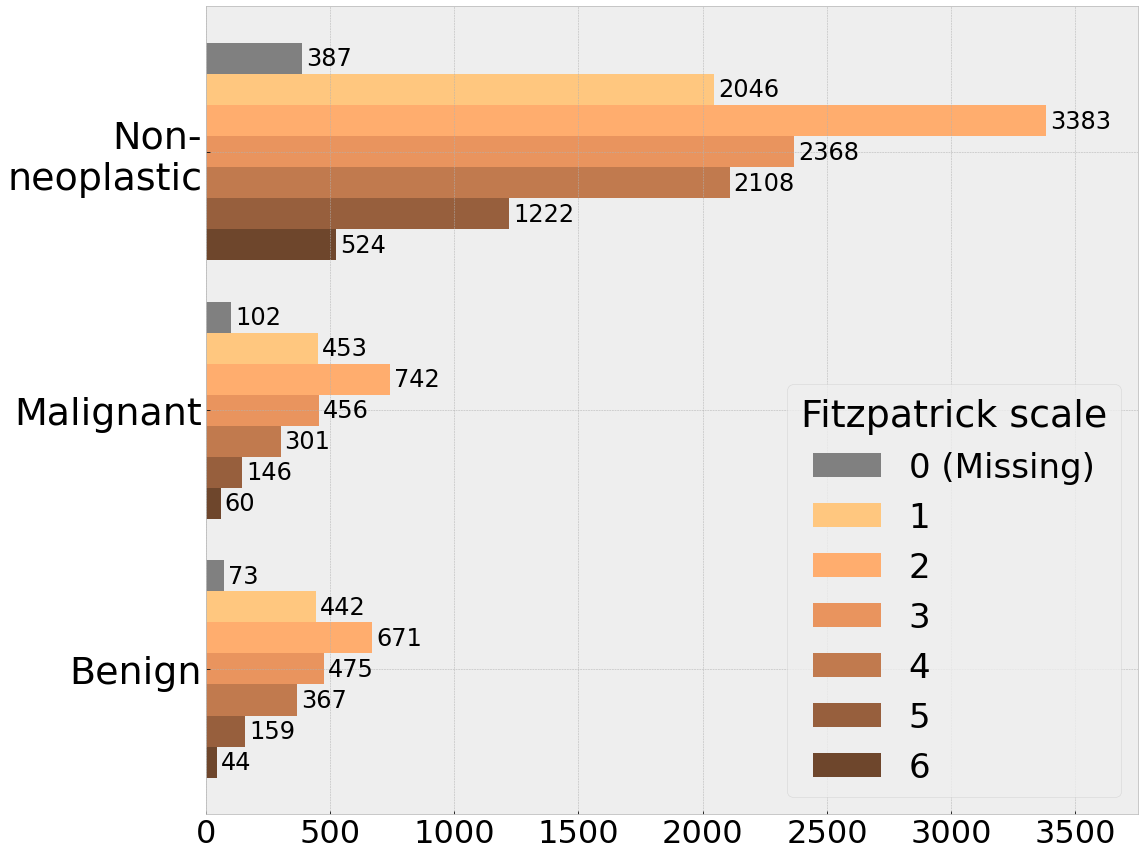

In [7]:
import matplotlib.pyplot as plt
import numpy as np

SKIN_COLORS = plt.cm.copper_r(np.linspace(0, 0.65, 6))
fontsize=24

classes = ['Benign', 'Malignant', 'Non-\nneoplastic']

x = np.arange(len(classes))  # the label locations
width = 0.12  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 12))

f0 = ax.barh(
    x + 3*width, 
    list(
        map(
            lambda x: x[1],
            sorted(
                skin_df.query(f'fitzpatrick == -1').three_partition_label.value_counts(sort=False).items()
            )

        )
    ),
    width, label='0 (Missing)', color='gray',
)
f1 = ax.barh(
    x + 2*width, 
    list(
        map(
            lambda x: x[1],
            sorted(
                skin_df.query(f'fitzpatrick == 1').three_partition_label.value_counts(sort=False).items()
            )

        )
    ),
    width, label='1', color=SKIN_COLORS[0]
)
f2 = ax.barh(
    x + width, 
    list(
        map(
            lambda x: x[1],
            sorted(
                skin_df.query(f'fitzpatrick == 2').three_partition_label.value_counts(sort=False).items()
            )

        )
    ),
    width, label='2', color=SKIN_COLORS[1]
)
f3 = ax.barh(
    x, 
    list(
        map(
            lambda x: x[1],
            sorted(
                skin_df.query(f'fitzpatrick == 3').three_partition_label.value_counts(sort=False).items()
            )

        )
    ),
    width, label='3', color=SKIN_COLORS[2]
)
f4 = ax.barh(
    x - width, 
    list(
        map(
            lambda x: x[1],
            sorted(
                skin_df.query(f'fitzpatrick == 4').three_partition_label.value_counts(sort=False).items()
            )

        )
    ),
    width, label='4', color=SKIN_COLORS[3]
)
f5 = ax.barh(
    x - 2*width, 
    list(
        map(
            lambda x: x[1],
            sorted(
                skin_df.query(f'fitzpatrick == 5').three_partition_label.value_counts(sort=False).items()
            )

        )
    ),
    width, label='5', color=SKIN_COLORS[4]
)
f6 = ax.barh(
    x - 3*width, 
    list(
        map(
            lambda x: x[1],
            sorted(
                skin_df.query(f'fitzpatrick == 6').three_partition_label.value_counts(sort=False).items()
            )

        )
    ),
    width, label='6', color=SKIN_COLORS[5]
)

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_title('Distribution of disease type by skin tone', fontsize=fontsize + 16)
ax.set_xlim(0, 3750)
ax.set_xticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500])
for t in ax.get_xticklabels():    #get_xticklabels will get you the label objects, same for y
    t.set_fontsize(fontsize + 8)
ax.set_yticks(x, classes, fontsize=fontsize + 14)
# ax.set_ylabel('Skin condition type', fontsize=fontsize + 8)

ax.legend(
    title='Fitzpatrick scale', 
    title_fontproperties={
        'style': 'normal',
        'size': fontsize + 14,
    },
    fontsize=fontsize + 10,
)

ax.bar_label(f0, padding=4, fontsize=fontsize)
ax.bar_label(f1, padding=4, fontsize=fontsize)
ax.bar_label(f2, padding=4, fontsize=fontsize)
ax.bar_label(f3, padding=4, fontsize=fontsize)
ax.bar_label(f4, padding=4, fontsize=fontsize)
ax.bar_label(f5, padding=4, fontsize=fontsize)
ax.bar_label(f6, padding=4, fontsize=fontsize)

fig.tight_layout()
plt.savefig(fig_dir / 'fitz-subgroup-class-dist.png')
plt.show()

In [121]:
skin_type_miss = skin_df.query('fitzpatrick == -1').three_partition_label.value_counts()
skin_type_1 = skin_df.query('fitzpatrick == 1').three_partition_label.value_counts()
skin_type_2 = skin_df.query('fitzpatrick == 2').three_partition_label.value_counts()
skin_type_3 = skin_df.query('fitzpatrick == 3').three_partition_label.value_counts()
skin_type_4 = skin_df.query('fitzpatrick == 4').three_partition_label.value_counts()
skin_type_5 = skin_df.query('fitzpatrick == 5').three_partition_label.value_counts()
skin_type_6 = skin_df.query('fitzpatrick == 6').three_partition_label.value_counts()
skin_type_all = skin_df.three_partition_label.value_counts()

In [141]:
def prevalence(group):
    total = group.sum()
    neo = group['non-neoplastic'] / total
    ben = group['benign'] / total
    mal = group['malignant'] / total
    print(f'{neo:.0%}')
    print(f'{ben:.0%}')
    print(f'{mal:.0%}')
    print(total)
    print()
    
prevalence(skin_type_miss)
prevalence(skin_type_1)
prevalence(skin_type_2)
prevalence(skin_type_3)
prevalence(skin_type_4)
prevalence(skin_type_5)
prevalence(skin_type_6)
# prevalence(skin_type_all)

69%
13%
18%
562

70%
15%
15%
2941

71%
14%
15%
4796

72%
14%
14%
3299

76%
13%
11%
2776

80%
10%
10%
1527

83%
7%
10%
628



In [8]:
total_6 = 524 + 60 + 44
total_5 = 1222 + 146 + 159
total_4 = 2108 + 301 + 367
total_3 = 2368 + 456 + 475
total_2 = 3383 + 742 + 671
total_1 = 2046 + 453 + 442
print(f'Non-neoplastic prevalence for 6 skin tone: {524 / (total_6):.3f}')
print(f'Non-neoplastic prevalence for 5 skin tone: {1222 / (total_5):.3f}')
print(f'Non-neoplastic prevalence for 4 skin tone: {2108 / (total_4):.3f}')
print(f'Non-neoplastic prevalence for 3 skin tone: {2368 / (total_3):.3f}')
print(f'Non-neoplastic prevalence for 2 skin tone: {3383 / (total_2):.3f}')
print(f'Non-neoplastic prevalence for 1 skin tone: {2046 / (total_1):.3f}')

print(f'Malignant prevalence for 6 skin tone: {60 / (total_6):.3f}')
print(f'Malignant prevalence for 5 skin tone: {146 / (total_5):.3f}')
print(f'Malignant prevalence for 4 skin tone: {301 / (total_4):.3f}')
print(f'Malignant prevalence for 3 skin tone: {456 / (total_3):.3f}')
print(f'Malignant prevalence for 2 skin tone: {742 / (total_2):.3f}')
print(f'Malignant prevalence for 1 skin tone: {453 / (total_1):.3f}')

print(f'Benign prevalence for 6 skin tone: {44 / (total_6):.3f}')
print(f'Benign prevalence for 5 skin tone: {159/ (total_5):.3f}')
print(f'Benign prevalence for 4 skin tone: {367/ (total_4):.3f}')
print(f'Benign prevalence for 3 skin tone: {475 / (total_3):.3f}')
print(f'Benign prevalence for 2 skin tone: {671/ (total_2):.3f}')
print(f'Benign prevalence for 1 skin tone: {442 / (total_1):.3f}')

Non-neoplastic prevalence for 6 skin tone: 0.834
Non-neoplastic prevalence for 5 skin tone: 0.800
Non-neoplastic prevalence for 4 skin tone: 0.759
Non-neoplastic prevalence for 3 skin tone: 0.718
Non-neoplastic prevalence for 2 skin tone: 0.705
Non-neoplastic prevalence for 1 skin tone: 0.696
Malignant prevalence for 6 skin tone: 0.096
Malignant prevalence for 5 skin tone: 0.096
Malignant prevalence for 4 skin tone: 0.108
Malignant prevalence for 3 skin tone: 0.138
Malignant prevalence for 2 skin tone: 0.155
Malignant prevalence for 1 skin tone: 0.154
Benign prevalence for 6 skin tone: 0.070
Benign prevalence for 5 skin tone: 0.104
Benign prevalence for 4 skin tone: 0.132
Benign prevalence for 3 skin tone: 0.144
Benign prevalence for 2 skin tone: 0.140
Benign prevalence for 1 skin tone: 0.150


In [9]:
label_map = dict(enumerate(sorted(skin_df.raw_label.unique())))
reversed_label_map = dict(zip(label_map.values(), label_map.keys()))

### Multiple runs

In [10]:
run_dir = pathlib.Path('/Users/charles.lu/AAAI/fitz/114_class_logits-run_2021_sep_01_13_53_48/')

valid_paths = {p.stem.replace('valid-res_', ''): p for p in run_dir.glob('valid-res_*')}
test_paths = {p.stem.replace('test-res_', ''): p for p in run_dir.glob('test-res_*')}

### Parse json results 

In [11]:
def parse(values):
    ret = {}
    image = values['meta']['image']
    label = values['meta']['label']
    subgroup = values['meta']['subgroup']
    ret['image'] = image
    ret['label'] = label
    ret['subgroup'] = subgroup
    
    #  group mc by class
    class_pred = collections.defaultdict(list)
    for k, v in values.items():
        if k.startswith('mc_'):
            for i, x in enumerate(v[0]):
                class_pred[i].append(x)
                
    for c, pred in class_pred.items():
        ret[f'pred_{c}'] = pred
        
    return ret

In [12]:
valid_dfs = {
    k: pd.DataFrame(list(map(parse, json.load(open(v)).values())))
    for k, v in valid_paths.items()
}
test_dfs = {
    k: pd.DataFrame(list(map(parse, json.load(open(v)).values())))
    for k, v in test_paths.items()
}

### Add logits

In [13]:
# number of  classses
C = 114

In [14]:
# aggregate predictions from each class
def get_logits(row):
    all_pred = [row[f'pred_{c}'] for c in range(C)]
    return np.array(all_pred).mean(1).tolist()
    
for k, df in valid_dfs.items():
    df['logits'] = df.apply(lambda row: get_logits(row), axis=1)

for k, df in test_dfs.items():
    df['logits'] = df.apply(lambda row: get_logits(row), axis=1)

### Platt scaling 

In [15]:
importlib.reload(platt)

<module 'platt' from '/Users/charles.lu/AAAI/AAAI-22/src/platt.py'>

In [16]:
for k, df in valid_dfs.items():
    # learn temperature weight using validation set
    T = platt.get_platt_scaling(df.label.values, [x for x in df.logits.values])
    valid_logits = torch.tensor([x for x in df.logits.values]) 
    df['scores'] = torch.softmax(valid_logits / T, axis=1).tolist()
   
    test_df = test_dfs[k]
    test_logits = torch.tensor([x for x in test_df.logits.values]) 
    test_df['scores'] = torch.softmax(test_logits / T, axis=1).tolist()

### Confidence levels $\alpha$

$$1 - \alpha \leq P(\hat{Y}_{n+1} \in \mathcal{C}(X_{n+1})) \leq 1 - \alpha + \frac{1}{n + 1}$$

In [17]:
# ALPHAS = [0.05] + [round(x, 1) for x in np.arange(0.1, 1.1, 0.1)]
ALPHAS = [round(x, 1) for x in np.arange(0.1, 1.1, 0.1)]
ALPHAS

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

### Conformal metrics

1. __Coverage__  - probability that the true class is contained within prediction set 
    * _Subgroup coverage_  - coverage per subgroup 
2. __Cardinality__ - expected prediction set size
    * _Subgroup cardinality_  - cardinality per subgroup 

In [18]:
A = list(range(len(df.subgroup.unique())))
A

[0, 1, 2, 3, 4, 5, 6]

In [19]:
def get_coverage(labels: list, prediction_sets: list) -> float:
    N = len(labels)
    assert N
    correct = 0
    for label, pred in zip(labels, prediction_sets):
        correct += 1 if label in pred else 0
    return correct / N

def get_subgroup_coverage(
        df, 
        pred_col,
        label_col='label',
        subgroup_col='subgroup',
        subgroups=A,
    ) -> dict:
    res = {}
    for a in subgroups:
        sub_df = df[df[subgroup_col] == a]
        res[a] = get_coverage(
            sub_df[label_col].values.tolist(),
            sub_df[pred_col].values.tolist(),
        )
    return res

def get_cardinality(prediction_sets: list) -> float:
    N = len(prediction_sets)
    assert N
    return sum([len(x) for x in prediction_sets]) / N

def get_subgroup_cardinality(
        df, 
        pred_col,
        subgroup_col='subgroup',
        subgroups=A,
    ) -> dict:
    res = {}
    for a in subgroups:
        sub_df = df[df[subgroup_col] == a]
        res[a] = get_cardinality(
            sub_df[pred_col].values.tolist(),
        )
    return res

### Helper functions

In [20]:
def aggregate_coverage(dfs, prefix, alphas=ALPHAS):
    # Collate prediction sets for all runs at different levels of coverage
    coverage_by_alpha = collections.defaultdict(list)
    for seed, df in dfs.items():
        for alpha in alphas:
            labels = [x for x in dfs[seed].label.values]
            prediction_sets = [x for x in dfs[seed][f'{prefix}_{alpha}'].values]
            coverage_by_alpha[alpha].append(get_coverage(labels, prediction_sets))
    
    coverage_by_alpha = dict(coverage_by_alpha)
    alpha, coverage = zip(*coverage_by_alpha.items())
    coverage = np.array(coverage)
    coverage_mean = coverage.mean(1)
    coverage_std = coverage.std(1)
    return alpha, coverage_mean, coverage_std
    
def aggregate_cardinality(dfs, prefix, alphas=ALPHAS):
    cardinality_by_alpha = collections.defaultdict(list)

    for seed, df in dfs.items():
        for alpha in ALPHAS:
            labels = [x for x in dfs[seed].label.values]
            prediction_sets = [x for x in dfs[seed][f'{prefix}_{alpha}'].values]
            cardinality_by_alpha[alpha].append(get_cardinality(prediction_sets))

    cardinality_by_alpha = dict(cardinality_by_alpha)
    alpha, cardinality = zip(*cardinality_by_alpha.items())
    cardinality = np.array(cardinality)
    cardinality_mean = cardinality.mean(1)
    cardinality_std = cardinality.std(1)
    return alpha, cardinality_mean, cardinality_std

In [21]:
# Helper functions for subgroup
def aggregate_coverage_subgroup(dfs, prefix, alphas=ALPHAS):
    # Collate prediction sets for all runs at different levels of coverage
    subgroup_coverage_by_alpha = collections.defaultdict(dict)
    for seed, df in dfs.items():
        for alpha in alphas:
            for sub, cov in get_subgroup_coverage(df, f'{prefix}_{alpha}').items():
                if sub in subgroup_coverage_by_alpha[alpha]:
                    subgroup_coverage_by_alpha[alpha][sub] += [cov]
                else:
                    subgroup_coverage_by_alpha[alpha][sub] = [cov]
    
    alpha, subgroup_cov = zip(*subgroup_coverage_by_alpha.items())

    coverage_mean = collections.defaultdict(list)
    coverage_std = collections.defaultdict(list)

    for res in subgroup_cov:
        for group, cov in res.items():
            cov = np.array(cov)
            coverage_mean[group].append(cov.mean())
            coverage_std[group].append(cov.std())

    coverage_mean = dict(coverage_mean)
    coverage_std = dict(coverage_std)
    
    return alpha, coverage_mean, coverage_std

    
def aggregate_cardinality_subgroup(dfs, prefix, alphas=ALPHAS):
    subgroup_cardinality_by_alpha = collections.defaultdict(dict)

    for seed, df in dfs.items():
        for alpha in ALPHAS:
            for sub, card in get_subgroup_cardinality(df, f'{prefix}_{alpha}').items():
                if sub in subgroup_cardinality_by_alpha[alpha]:
                    subgroup_cardinality_by_alpha[alpha][sub] += [card]
                else:
                    subgroup_cardinality_by_alpha[alpha][sub] = [card]

    subgroup_cardinality_by_alpha = dict(subgroup_cardinality_by_alpha)
    alpha, cardinality = zip(*subgroup_cardinality_by_alpha.items())
    
    cardinality_mean = collections.defaultdict(list)
    cardinality_std = collections.defaultdict(list)

    for res in cardinality:
        for group, card in res.items():
            card = np.array(card)
            cardinality_mean[group].append(card.mean())
            cardinality_std[group].append(card.std())

    cardinality_mean = dict(cardinality_mean)
    cardinality_std = dict(cardinality_std)
    
    return alpha, cardinality_mean, cardinality_std

### Naive prediction sets

* platt scaling
* take from sorted scores until cumulative sum exceeds $1 - \alpha$

In [22]:
print('naive quantile', 
      torch.quantile(torch.tensor(
          [1 - row.scores[row.label] for i, row in  df.iterrows()]
      ), np.ceil((len(df) + 1)*(1 - 0.1))/len(df))
     )

naive quantile tensor(0.9973)


In [23]:
naive_qhat = {}
for k, df in valid_dfs.items():
    scores = [x for x in df.scores.values]
    labels = [x for x in df.label.values]
    s = torch.tensor([1 - s[l] for s, l in zip(scores, labels)])
    n = len(df)
    for alpha in ALPHAS:
        p = np.ceil((n + 1) * (1 - alpha)) / n
        naive_qhat[alpha] = torch.quantile(s, p).item()
        
for k, df in test_dfs.items():
    scores = np.array([x for x in df.scores.values])
    for alpha in ALPHAS:
        df[f'naive_{alpha}'] = [np.nonzero(s > (1 - naive_qhat[alpha]))[0] for s in scores]

In [24]:
columns = [f'naive_{alpha}' for alpha in ALPHAS]
test_dfs['seed_0'][columns].head()

,naive_0.1,naive_0.2,naive_0.3,naive_0.4,naive_0.5,naive_0.6,naive_0.7,naive_0.8,naive_0.9,naive_1.0
0,"[1, 3, 5, 6, 8, 12, 13, 15, 17, 21, 22, 23, 26...","[1, 3, 5, 6, 8, 13, 22, 27, 30, 31, 32, 34, 36...","[5, 6, 8, 31, 32, 42, 43, 48, 51, 63, 64, 68, ...","[6, 8, 31, 32, 42, 43, 48, 63, 64, 68, 75, 85,...","[31, 48, 63, 64, 85, 86]","[48, 64, 85, 86]",[64],[],[],[]
1,"[1, 2, 5, 6, 7, 8, 11, 13, 15, 17, 19, 20, 22,...","[2, 5, 6, 8, 11, 13, 15, 17, 19, 22, 28, 31, 3...","[5, 6, 8, 13, 17, 19, 22, 28, 31, 32, 36, 48, ...","[5, 6, 13, 19, 28, 31, 36, 48, 51, 68, 84, 86,...","[31, 36, 51, 84, 86, 98]",[86],[],[],[],[]
2,"[1, 2, 3, 5, 6, 8, 9, 11, 13, 14, 15, 16, 17, ...","[1, 2, 5, 6, 8, 13, 15, 17, 19, 20, 22, 28, 32...","[1, 2, 5, 6, 8, 13, 19, 20, 22, 51, 52, 54, 60...","[1, 2, 5, 6, 20, 51, 60, 92, 98]","[1, 2, 5, 60, 98]",[2],[],[],[],[]
3,"[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1...","[2, 5, 6, 7, 8, 13, 14, 16, 17, 19, 22, 26, 28...","[2, 6, 8, 14, 16, 17, 19, 28, 40, 48, 56, 68, ...","[2, 8, 48, 86, 91, 100, 110]","[2, 8, 91]","[2, 91]",[2],[],[],[]
4,"[1, 2, 3, 5, 6, 8, 9, 10, 12, 16, 17, 18, 19, ...","[1, 2, 5, 6, 8, 12, 16, 18, 21, 22, 24, 34, 37...","[2, 5, 6, 12, 16, 37, 41, 44, 48, 53, 55, 57, ...","[2, 6, 12, 16, 41, 44, 53, 69, 93, 103, 110]","[2, 6, 53, 103]",[103],[],[],[],[]


In [25]:
alpha, naive_coverage_mean, naive_coverage_std = aggregate_coverage(test_dfs, prefix='naive')
alpha, naive_cardinality_mean, naive_cardinality_std = aggregate_cardinality(test_dfs, prefix='naive')

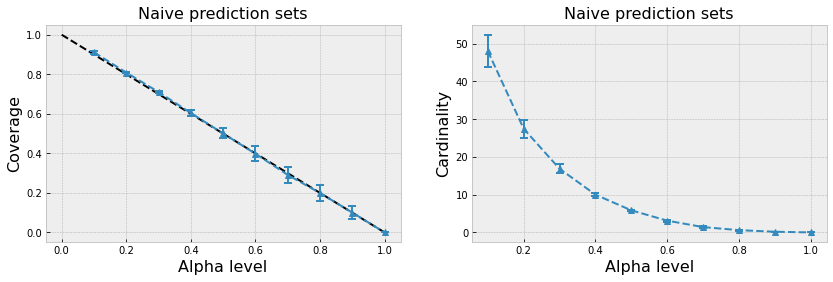

In [26]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].errorbar(
    alpha, naive_coverage_mean, yerr=naive_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].set_title('Naive prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, naive_cardinality_mean, yerr=naive_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('Naive prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Adaptive prediction set (APS)

* Calibration set for correct marginal coverage

In [27]:
importlib.reload(conformal)

<module 'conformal' from '/Users/charles.lu/AAAI/AAAI-22/src/conformal.py'>

In [28]:
# calibrate 
aps_qhat = collections.defaultdict(dict)
for k, df in valid_dfs.items():
    scores = [x for x in df.scores.values]
    labels = [x for x in df.label.values]
    for alpha in ALPHAS:
        qhat = conformal.get_q_hat(scores, labels, alpha=alpha)
        aps_qhat[k][alpha] = qhat.item()
        
aps_qhat = dict(aps_qhat)

In [29]:
print(aps_qhat['seed_0'][0.1])

0.93365478515625


In [30]:
# inference
for k, df in test_dfs.items():
    scores = [x for x in df.scores.values]
    for alpha in ALPHAS:
        qhat = aps_qhat[k][alpha]
        df[f'aps_{alpha}'] = conformal.conformal_inference(scores, qhat)

In [31]:
columns = [f'aps_{alpha}' for alpha in ALPHAS]
test_dfs['seed_0'][columns].head()

,aps_0.1,aps_0.2,aps_0.3,aps_0.4,aps_0.5,aps_0.6,aps_0.7,aps_0.8,aps_0.9,aps_1.0
0,"[64, 48, 86, 85, 31, 63, 6, 43, 91, 42, 32, 75...","[64, 48, 86, 85, 31, 63, 6, 43, 91, 42, 32, 75...","[64, 48, 86, 85, 31, 63, 6, 43, 91, 42, 32, 75...","[64, 48, 86, 85, 31, 63, 6, 43, 91, 42, 32, 75...","[64, 48, 86, 85, 31, 63, 6, 43, 91, 42, 32, 75]","[64, 48, 86, 85, 31, 63, 6, 43]","[64, 48, 86, 85, 31]","[64, 48, 86]","[64, 48]",[64]
1,"[86, 98, 36, 51, 84, 31, 92, 19, 6, 91, 5, 48,...","[86, 98, 36, 51, 84, 31, 92, 19, 6, 91, 5, 48,...","[86, 98, 36, 51, 84, 31, 92, 19, 6, 91, 5, 48,...","[86, 98, 36, 51, 84, 31, 92, 19, 6, 91, 5, 48,...","[86, 98, 36, 51, 84, 31, 92, 19, 6, 91, 5, 48,...","[86, 98, 36, 51, 84, 31, 92, 19, 6, 91, 5]","[86, 98, 36, 51, 84, 31, 92, 19]","[86, 98, 36, 51, 84]","[86, 98, 36]",[86]
2,"[2, 5, 60, 98, 1, 6, 51, 20, 92, 54, 95, 8, 22...","[2, 5, 60, 98, 1, 6, 51, 20, 92, 54, 95, 8, 22...","[2, 5, 60, 98, 1, 6, 51, 20, 92, 54, 95, 8, 22...","[2, 5, 60, 98, 1, 6, 51, 20, 92, 54, 95, 8, 22...","[2, 5, 60, 98, 1, 6, 51, 20, 92, 54, 95, 8, 22...","[2, 5, 60, 98, 1, 6, 51, 20, 92, 54, 95, 8, 22]","[2, 5, 60, 98, 1, 6, 51, 20, 92]","[2, 5, 60, 98, 1]","[2, 5, 60]",[2]
3,"[2, 91, 8, 48, 86, 100, 110, 75, 98, 14, 68, 1...","[2, 91, 8, 48, 86, 100, 110, 75, 98, 14, 68, 1...","[2, 91, 8, 48, 86, 100, 110, 75, 98, 14, 68, 1...","[2, 91, 8, 48, 86, 100, 110, 75, 98, 14, 68, 1...","[2, 91, 8, 48, 86, 100, 110, 75, 98, 14, 68, 1...","[2, 91, 8, 48, 86, 100, 110, 75, 98, 14, 68, 19]","[2, 91, 8, 48, 86, 100, 110, 75]","[2, 91, 8, 48]","[2, 91]",[2]
4,"[103, 6, 53, 2, 41, 93, 44, 110, 12, 69, 16, 5...","[103, 6, 53, 2, 41, 93, 44, 110, 12, 69, 16, 5...","[103, 6, 53, 2, 41, 93, 44, 110, 12, 69, 16, 5...","[103, 6, 53, 2, 41, 93, 44, 110, 12, 69, 16, 5...","[103, 6, 53, 2, 41, 93, 44, 110, 12, 69, 16, 5...","[103, 6, 53, 2, 41, 93, 44, 110, 12, 69, 16, 55]","[103, 6, 53, 2, 41, 93, 44, 110, 12]","[103, 6, 53, 2, 41, 93]","[103, 6, 53]",[103]


In [32]:
alpha, aps_coverage_mean, aps_coverage_std = aggregate_coverage(test_dfs, prefix='aps')
alpha, aps_cardinality_mean, aps_cardinality_std = aggregate_cardinality(test_dfs, prefix='aps')

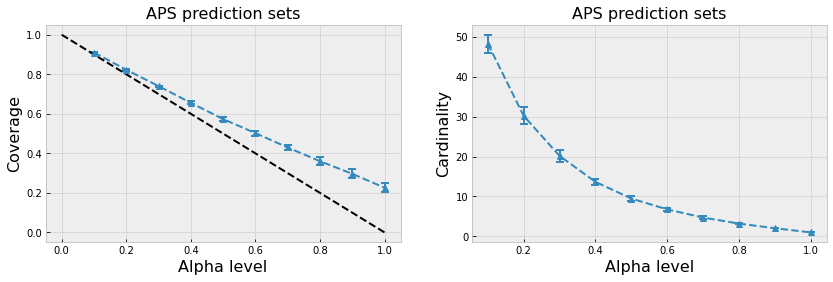

In [33]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, aps_coverage_mean, yerr=aps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('APS prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, aps_cardinality_mean, yerr=aps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('APS prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Group APS (GAPS)

Conformal calibration for each subgroup 

In [34]:
# calibrate 
gaps_qhat = collections.defaultdict(dict)

for k, df in valid_dfs.items():
    alpha_qhat = collections.defaultdict(dict)
    for alpha in ALPHAS:
        group_qhat = collections.defaultdict(dict)
        for a in A:
            group_df = df[df.subgroup == a]
            
            scores = [x for x in group_df.scores.values]
            labels = [x for x in group_df.label.values]
            qhat = conformal.get_q_hat(scores, labels, alpha=alpha)
            gaps_qhat[k][alpha] = qhat.item()

            group_qhat[a] = qhat
            
        alpha_qhat[alpha] = dict(group_qhat)
        
    gaps_qhat[k] = dict(alpha_qhat)

gaps_qhat = dict(gaps_qhat)

In [35]:
print(gaps_qhat['seed_0'][0.1])

{0: tensor(0.9406), 1: tensor(0.9648), 2: tensor(0.9219), 3: tensor(0.9293), 4: tensor(0.9293), 5: tensor(0.9086), 6: tensor(0.9692)}


In [36]:
# inference

for k, df in test_dfs.items():
    temp = []
    scores = np.array([x for x in df.scores.values])
    index, ordered, cumsum = conformal.sort_sum(scores)
    for a in A:
        group_df = df[df.subgroup == a].copy()
        
        # APS
        scores = [x for x in group_df.scores.values]
        for alpha in ALPHAS:
            qhat = gaps_qhat[k][alpha][a]
            group_df[f'gaps_{alpha}'] = conformal.conformal_inference(scores, qhat)
        
        temp.append(group_df)
    test_dfs[k] = pd.concat(temp)

In [37]:
# columns = [f'gaps_{alpha}' for alpha in ALPHAS]
columns = [f'gaps_{alpha}' for alpha in ALPHAS]
test_dfs['seed_0'][columns].head()

,gaps_0.1,gaps_0.2,gaps_0.3,gaps_0.4,gaps_0.5,gaps_0.6,gaps_0.7,gaps_0.8,gaps_0.9,gaps_1.0
21,"[98, 8, 33, 86, 48, 13, 5, 82, 59, 11, 91, 97,...","[98, 8, 33, 86, 48, 13, 5, 82, 59, 11, 91, 97,...","[98, 8, 33, 86, 48, 13, 5, 82, 59, 11, 91, 97,...","[98, 8, 33, 86, 48, 13, 5, 82, 59, 11, 91, 97,...","[98, 8, 33, 86, 48, 13, 5, 82, 59, 11, 91, 97]","[98, 8, 33, 86, 48, 13, 5, 82]","[98, 8, 33, 86, 48]","[98, 8, 33]","[98, 8]",[98]
43,"[98, 13, 84, 31, 51, 19, 45, 86, 93, 15, 75, 2...","[98, 13, 84, 31, 51, 19, 45, 86, 93, 15, 75, 2...","[98, 13, 84, 31, 51, 19, 45, 86, 93, 15, 75, 2...","[98, 13, 84, 31, 51, 19, 45, 86, 93, 15, 75, 2...","[98, 13, 84, 31, 51, 19, 45, 86, 93, 15, 75, 2...","[98, 13, 84, 31, 51, 19, 45, 86, 93, 15]","[98, 13, 84, 31, 51, 19, 45]","[98, 13, 84, 31]","[98, 13]",[98]
82,"[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55]","[48, 6, 19, 86]","[48, 6]"
129,"[51, 19, 86, 17, 92, 60, 52, 28, 2, 75, 5, 95,...","[51, 19, 86, 17, 92, 60, 52, 28, 2, 75, 5, 95,...","[51, 19, 86, 17, 92, 60, 52, 28, 2, 75, 5, 95,...","[51, 19, 86, 17, 92, 60, 52, 28, 2, 75, 5, 95,...","[51, 19, 86, 17, 92, 60, 52, 28, 2, 75]","[51, 19, 86, 17, 92, 60, 52]","[51, 19, 86, 17, 92]","[51, 19, 86]",[51],[51]
203,"[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 6...","[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 6...","[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 6...","[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 6...","[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 6...","[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 68]","[8, 86, 56, 98, 108, 88, 5, 91, 48]","[8, 86, 56, 98]","[8, 86]",[8]


### Regularized adaptive prediction set (RAPS)

* Calibration set for correct marginal coverage
* Parameterized regulaization penality $\lambda$ and $K$

In [38]:
K_REG = 10
LAMBDA = 1e-4

penalty = np.zeros((1, C))
penalty[:, K_REG:] += LAMBDA

# randomized
RAND = True

# allow zero sets
ZERO = True  

In [40]:
# calibrate 
raps_qhat = collections.defaultdict(dict)
for k, df in valid_dfs.items():
    scores = np.array([x for x in df.scores.values])
    labels = np.array([x for x in df.label.values])
    index, ordered, cumsum = conformal.sort_sum(scores)
    for alpha in ALPHAS:
        qhat = conformal.raps_calibrate(
            scores, labels, index, ordered, cumsum,
            penalty, randomized=RAND, allow_zero_sets=ZERO, alpha=alpha
        )
        raps_qhat[k][alpha] = qhat
        
raps_qhat = dict(raps_qhat)

In [41]:
print(raps_qhat['seed_0'][0.1])

0.9362762558665821


In [42]:
# inference
for k, df in test_dfs.items():
    scores = np.array([x for x in df.scores.values])
    index, ordered, cumsum = conformal.sort_sum(scores)
    for alpha in ALPHAS:
        qhat = raps_qhat[k][alpha]
        df[f'raps_{alpha}'] = conformal.raps_predict(
            C, qhat, index, ordered, cumsum, 
            penalty, randomized=RAND, allow_zero_sets=ZERO,
        )

In [43]:
columns = [f'raps_{alpha}' for alpha in ALPHAS]
test_dfs['seed_0'][columns].head()

,raps_0.1,raps_0.2,raps_0.3,raps_0.4,raps_0.5,raps_0.6,raps_0.7,raps_0.8,raps_0.9,raps_1.0
21,"[98, 8, 33, 86, 48, 13, 5, 82, 59, 11, 91, 97,...","[98, 8, 33, 86, 48, 13, 5, 82, 59, 11, 91, 97,...","[98, 8, 33, 86, 48, 13, 5, 82, 59, 11, 91, 97,...","[98, 8, 33, 86, 48, 13, 5, 82, 59, 11, 91, 97,...","[98, 8, 33, 86, 48, 13, 5, 82, 59, 11, 91]","[98, 8, 33, 86, 48, 13]","[98, 8, 33, 86]","[98, 8]",[98],[]
43,"[98, 13, 84, 31, 51, 19, 45, 86, 93, 15, 75, 2...","[98, 13, 84, 31, 51, 19, 45, 86, 93, 15, 75, 2...","[98, 13, 84, 31, 51, 19, 45, 86, 93, 15, 75, 2...","[98, 13, 84, 31, 51, 19, 45, 86, 93, 15, 75, 2...","[98, 13, 84, 31, 51, 19, 45, 86, 93, 15, 75, 2]","[98, 13, 84, 31, 51, 19, 45, 86]","[98, 13, 84, 31, 51, 19]","[98, 13, 84, 31]","[98, 13]",[98]
82,"[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75]","[48, 6, 19, 86, 13, 2, 33]","[48, 6, 19, 86]",[48]
129,"[51, 19, 86, 17, 92, 60, 52, 28, 2, 75, 5, 95,...","[51, 19, 86, 17, 92, 60, 52, 28, 2, 75, 5, 95,...","[51, 19, 86, 17, 92, 60, 52, 28, 2, 75, 5, 95,...","[51, 19, 86, 17, 92, 60, 52, 28, 2, 75, 5, 95]","[51, 19, 86, 17, 92, 60, 52, 28, 2]","[51, 19, 86, 17, 92, 60]","[51, 19, 86, 17]","[51, 19]",[51],[]
203,"[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 6...","[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 6...","[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 6...","[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 6...","[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 6...","[8, 86, 56, 98, 108, 88, 5, 91, 48, 102]","[8, 86, 56, 98, 108, 88, 5]","[8, 86, 56]","[8, 86]",[]


In [44]:
alpha, raps_coverage_mean, raps_coverage_std = aggregate_coverage(test_dfs, prefix='raps')
alpha, raps_cardinality_mean, raps_cardinality_std = aggregate_cardinality(test_dfs, prefix='raps')

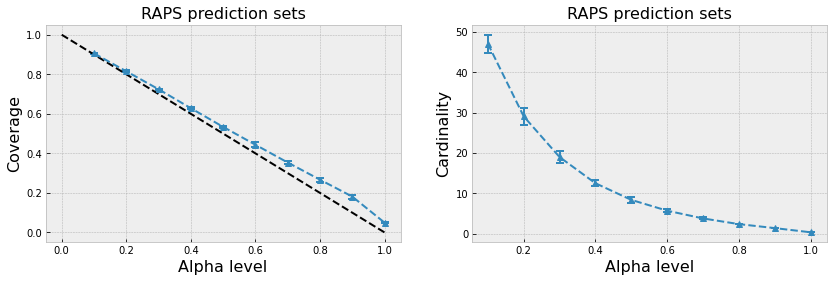

In [45]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, raps_coverage_mean, yerr=raps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('RAPS prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, raps_cardinality_mean, yerr=raps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('RAPS prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Group RAPS (GRAPS)

In [46]:
# calibrate 
graps_qhat = collections.defaultdict(dict)

for k, df in valid_dfs.items():
    alpha_qhat = collections.defaultdict(dict)
    for alpha in ALPHAS:
        group_qhat = collections.defaultdict(dict)
        for a in A:
            group_df = df[df.subgroup == a]
            
            scores = np.array([x for x in group_df.scores.values])
            labels = np.array([x for x in group_df.label.values])
            index, ordered, cumsum = conformal.sort_sum(scores)
            qhat = conformal.raps_calibrate(
                scores, labels, index, ordered, cumsum,
                penalty, randomized=RAND, allow_zero_sets=ZERO, alpha=alpha
            )
            
            group_qhat[a] = qhat
            
        alpha_qhat[alpha] = dict(group_qhat)
        
    graps_qhat[k] = dict(alpha_qhat)

graps_qhat = dict(graps_qhat)


In [47]:
print(graps_qhat['seed_0'][0.10])

{0: 0.937289768843032, 1: 0.9682924210809513, 2: 0.9214879141562645, 3: 0.929565484637575, 4: 0.9249176929871759, 5: 0.9072374231820006, 6: 0.9664616135490726}


In [48]:
# inference

for k, df in test_dfs.items():
    temp = []
    scores = np.array([x for x in df.scores.values])
    index, ordered, cumsum = conformal.sort_sum(scores)
    for a in A:
        group_df = df[df.subgroup == a].copy()
        
        # RAPS
        scores = np.array([x for x in group_df.scores.values])
        for alpha in ALPHAS:
            qhat = graps_qhat[k][alpha][a]
            index, ordered, cumsum = conformal.sort_sum(scores)
            group_df[f'graps_{alpha}'] = conformal.raps_predict(
                C, qhat.item(), index, ordered, cumsum, 
                penalty, randomized=RAND, allow_zero_sets=ZERO,
            )
            
        temp.append(group_df)
    test_dfs[k] = pd.concat(temp)

In [49]:
# columns = [f'gaps_{alpha}' for alpha in ALPHAS]
columns = [f'graps_{alpha}' for alpha in ALPHAS]
test_dfs['seed_0'][columns].head()

,graps_0.1,graps_0.2,graps_0.3,graps_0.4,graps_0.5,graps_0.6,graps_0.7,graps_0.8,graps_0.9,graps_1.0
21,"[98, 8, 33, 86, 48, 13, 5, 82, 59, 11, 91, 97,...","[98, 8, 33, 86, 48, 13, 5, 82, 59, 11, 91, 97,...","[98, 8, 33, 86, 48, 13, 5, 82, 59, 11, 91, 97,...","[98, 8, 33, 86, 48, 13, 5, 82, 59, 11, 91, 97,...","[98, 8, 33, 86, 48, 13, 5, 82, 59, 11, 91, 97]","[98, 8, 33, 86, 48, 13, 5, 82]","[98, 8, 33, 86]","[98, 8]",[98],[98]
43,"[98, 13, 84, 31, 51, 19, 45, 86, 93, 15, 75, 2...","[98, 13, 84, 31, 51, 19, 45, 86, 93, 15, 75, 2...","[98, 13, 84, 31, 51, 19, 45, 86, 93, 15, 75, 2...","[98, 13, 84, 31, 51, 19, 45, 86, 93, 15, 75, 2...","[98, 13, 84, 31, 51, 19, 45, 86, 93, 15, 75, 2]","[98, 13, 84, 31, 51, 19, 45, 86, 93]","[98, 13, 84, 31, 51]","[98, 13, 84]",[98],[98]
82,"[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75, 17...","[48, 6, 19, 86, 13, 2, 33, 55, 111, 68, 75]","[48, 6, 19, 86, 13, 2, 33]","[48, 6, 19, 86]",[48]
129,"[51, 19, 86, 17, 92, 60, 52, 28, 2, 75, 5, 95,...","[51, 19, 86, 17, 92, 60, 52, 28, 2, 75, 5, 95,...","[51, 19, 86, 17, 92, 60, 52, 28, 2, 75, 5, 95,...","[51, 19, 86, 17, 92, 60, 52, 28, 2, 75, 5, 95,...","[51, 19, 86, 17, 92, 60, 52, 28, 2]","[51, 19, 86, 17, 92, 60]","[51, 19, 86, 17]","[51, 19]",[51],[51]
203,"[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 6...","[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 6...","[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 6...","[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 6...","[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19, 6...","[8, 86, 56, 98, 108, 88, 5, 91, 48, 102, 19]","[8, 86, 56, 98, 108, 88, 5]","[8, 86, 56]","[8, 86]",[8]


In [50]:
alpha, gaps_coverage_mean, gaps_coverage_std = aggregate_coverage(test_dfs, prefix='gaps')
alpha, gaps_cardinality_mean, gaps_cardinality_std = aggregate_cardinality(test_dfs, prefix='gaps')
alpha, graps_coverage_mean, graps_coverage_std = aggregate_coverage(test_dfs, prefix='graps')
alpha, graps_cardinality_mean, graps_cardinality_std = aggregate_cardinality(test_dfs, prefix='graps')

In [51]:
gaps_coverage_mean, gaps_coverage_std

(array([0.91044776, 0.82283179, 0.74033885, 0.65675676, 0.57482856,
        0.50237999, 0.43340056, 0.3614764 , 0.29770069, 0.22787414]),
 array([0.00430134, 0.00549053, 0.00419524, 0.0084475 , 0.00835803,
        0.0135885 , 0.01667483, 0.01811362, 0.02119921, 0.02121931]))

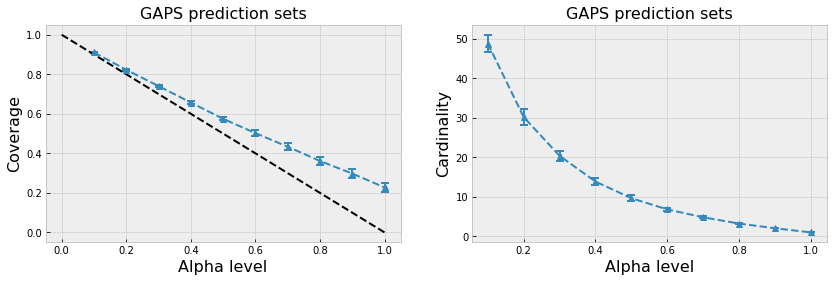

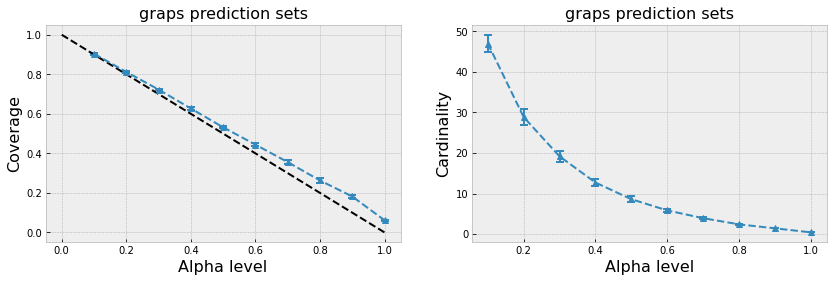

In [52]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, gaps_coverage_mean, yerr=gaps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('GAPS prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, gaps_cardinality_mean, yerr=gaps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('GAPS prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, graps_coverage_mean, yerr=graps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('graps prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, graps_cardinality_mean, yerr=graps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('graps prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Overall comparison

In [53]:
# jitter = np.random.randn(*naive_coverage_mean.shape) / 90

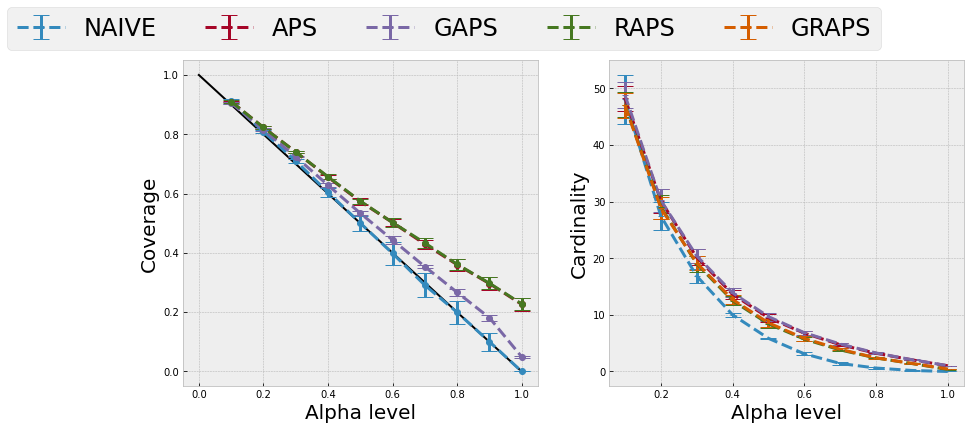

In [54]:
capsize = 8
fontsize=20
capthick=1
lw = 3
marker='o'
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
ax[0].plot([1, 0], [0, 1], c='k', label='Ideal Coverage')
ax[0].errorbar(
    alpha, naive_coverage_mean, yerr=naive_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='NAIVE',
)
ax[0].errorbar(
    alpha, aps_coverage_mean, yerr=aps_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='APS',
)
ax[0].errorbar(
    alpha, raps_coverage_mean, yerr=raps_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='RAPS',
)
ax[0].errorbar(
    alpha, gaps_coverage_mean , yerr=gaps_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='GAPS',
)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, naive_cardinality_mean, yerr=naive_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='NAIVE',
)
ax[1].errorbar(
    alpha, aps_cardinality_mean, yerr=aps_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='APS',
)
ax[1].errorbar(
    alpha, gaps_cardinality_mean , yerr=gaps_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='GAPS',
)
ax[1].errorbar(
    alpha, raps_cardinality_mean, yerr=raps_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='RAPS',
)
ax[1].errorbar(
    alpha, graps_cardinality_mean , yerr=graps_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='GRAPS',
)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.legend(fontsize=fontsize + 4, bbox_to_anchor=(0.8, 1.2), ncol=5)
plt.savefig(fig_dir / 'fitz-compare.png')
plt.show()

### Subgroup comparison

In [55]:
alpha, naive_subgroup_coverage_mean, naive_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_dfs, prefix='naive'
)
alpha, naive_subgroup_cardinality_mean, naive_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_dfs, prefix='naive'
)
alpha, aps_subgroup_coverage_mean, aps_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_dfs, prefix='aps'
)
alpha, aps_subgroup_cardinality_mean, aps_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_dfs, prefix='aps'
)
alpha, raps_subgroup_coverage_mean, raps_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_dfs, prefix='raps'
)
alpha, raps_subgroup_cardinality_mean, raps_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_dfs, prefix='raps'
)
alpha, gaps_subgroup_coverage_mean, gaps_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_dfs, prefix='gaps'
)
alpha, gaps_subgroup_cardinality_mean, gaps_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_dfs, prefix='gaps'
)
alpha, graps_subgroup_coverage_mean, graps_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_dfs, prefix='graps'
)
alpha, graps_subgroup_cardinality_mean, graps_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_dfs, prefix='graps'
)

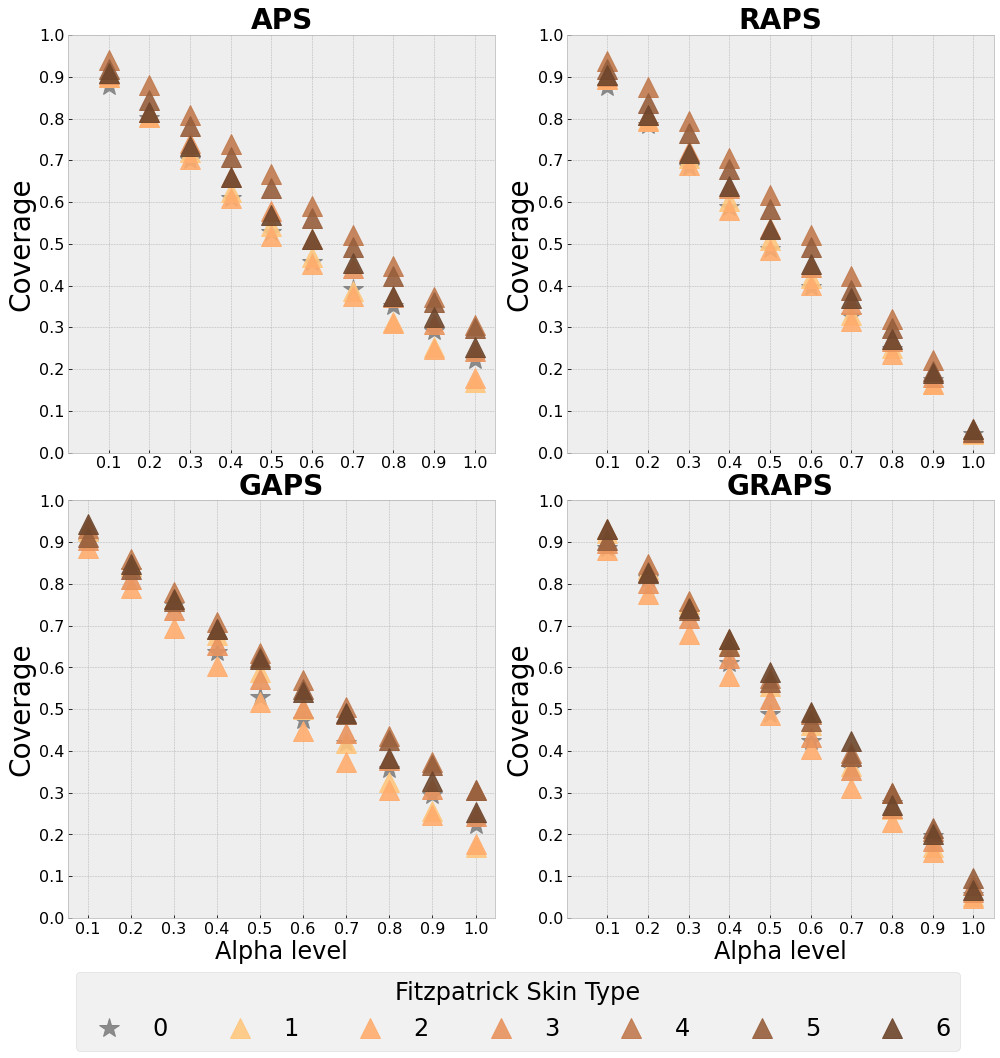

In [393]:
## fontsize=28
labelsize=16
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 16), sharex=False, sharey=False)
ls=''
lw=6
marker = '^'
ms = 20
alpha=0.9
xticks = np.arange(0.1, 1.1, 0.1)
yticks = np.arange(0, 1.1, 0.1)
xlim = (0, 1.05)
ylim = (0.01, 1.0)


# for i, (k, v) in enumerate(naive_subgroup_coverage_mean.items()):
#     ax[0, 0].plot(ALPHAS, v, label=f'{k}', ls=ls, lw=lw, alpha=alpha, marker=marker if i != 0 else '*', ms=ms, c=color[i] if i != 0 else 'darkgray')
# ax[0, 0].set_title('NAIVE', fontsize=fontsize)
# ax[0, 0].set_ylabel('Coverage', fontsize=fontsize)
# ax[0, 0].set_xticks(xticks)
# ax[0, 0].tick_params(axis='x', labelsize=labelsize)
# ax[0, 0].tick_params(axis='y', labelsize=labelsize)

# ax[0, 0].plot([0.1, 1], [1, 0], '--', c='k')
for i, (k, v) in enumerate(aps_subgroup_coverage_mean.items()):
    ax[0, 0].plot(ALPHAS, v, label=f'{k}', ls=ls, lw=lw, alpha=alpha, marker=marker if i != 0 else '*', ms=ms, c=SKIN_COLORS[i -1] if i != 0 else 'gray')
# ax[0, 0].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[0, 0].text(0.08, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
ax[0, 0].set_title('APS', fontsize=fontsize , fontweight='bold')
ax[0, 0].set_xlim(*xlim)
ax[0, 0].set_ylim(*ylim)
# ax[0, 0].set_xlabel('Alpha level', fontsize=fontsize - 4)
ax[0, 0].set_ylabel('Coverage', fontsize=fontsize)
ax[0, 0].set_xticks(xticks)
ax[0, 0].set_yticks(yticks)
ax[0, 0].tick_params(axis='x', labelsize=labelsize)
ax[0, 0].tick_params(axis='y', labelsize=labelsize)

# ax[1, 0].plot([0.1, 1], [1, 0], '--', c='k')
for i, (k, v) in enumerate(raps_subgroup_coverage_mean.items()):
    ax[0, 1].plot(ALPHAS, v, label=f'{k}', ls=ls, lw=lw, alpha=alpha, marker=marker if i != 0 else '*', ms=ms, c=SKIN_COLORS[i-1] if i != 0 else 'gray')
# ax[1, 0].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[1, 0].text(0.08, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
ax[0, 1].set_title('RAPS', fontsize=fontsize , fontweight='bold')
ax[0, 1].set_xlim(*xlim)
ax[0, 1].set_ylim(*ylim)
# ax[0, 1].set_xlabel('Alpha level', fontsize=fontsize-4)
ax[0, 1].set_ylabel('Coverage', fontsize=fontsize)
ax[0, 1].set_xticks(xticks)
ax[0, 1].set_yticks(yticks)
ax[0, 1].tick_params(axis='x', labelsize=labelsize)
ax[0, 1].tick_params(axis='y', labelsize=labelsize)

# ax[0, 1].plot([0, 1], [1, 0], '--', c='k')
for i, (k, v) in enumerate(gaps_subgroup_coverage_mean.items()):
    ax[1, 0].plot(ALPHAS, v, label=f'{k}', ls=ls, lw=lw, alpha=alpha, marker=marker if i != 0 else '*', ms=ms, c=SKIN_COLORS[i-1] if i != 0 else 'gray')
# ax[0, 1].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[0, 1].text(0.08, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
ax[1, 0].set_title('GAPS', fontsize=fontsize , fontweight='bold')
ax[1, 0].set_ylim(*ylim)
ax[1, 0].set_ylim(*ylim)
ax[1, 0].set_xlabel('Alpha level', fontsize=fontsize-4)
ax[1, 0].set_ylabel('Coverage', fontsize=fontsize)
ax[1, 0].set_xticks(xticks)
ax[1, 0].set_yticks(yticks)
ax[1, 0].tick_params(axis='x', labelsize=labelsize )
ax[1, 0].tick_params(axis='y', labelsize=labelsize)

# ax[1, 1].plot([0, 1], [1, 0], '--', c='k')
for i, (k, v) in enumerate(graps_subgroup_coverage_mean.items()):
    ax[1, 1].plot(ALPHAS, v, label=f'{k}', ls=ls, lw=lw, alpha=alpha, marker=marker if i != 0 else '*', ms=ms, c=SKIN_COLORS[i-1] if i != 0 else 'gray')
# ax[1, 1].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[1, 1].text(0.08, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
ax[1, 1].set_title('GRAPS', fontsize=fontsize , fontweight='bold')
ax[1, 1].set_xlim(*xlim)
ax[1, 1].set_ylim(*ylim)
ax[1, 1].set_xlabel('Alpha level', fontsize=fontsize-4)
ax[1, 1].set_ylabel('Coverage', fontsize=fontsize)
ax[1, 1].set_xticks(xticks)
ax[1, 1].set_yticks(yticks)
ax[1, 1].tick_params(axis='x', labelsize=labelsize )
ax[1, 1].tick_params(axis='y', labelsize=labelsize)

handles, labels = ax[0, 0].get_legend_handles_labels()

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.legend(
    handles,
    labels,
    title='Fitzpatrick Skin Type', 
    title_fontproperties={
        'style': 'normal',
        'size': fontsize-4,
    },
    fontsize=fontsize-4,
    bbox_to_anchor=(0.95, -0.10, -0.0, 0),
    ncol=7,
)

plt.savefig(fig_dir / 'fitz-subgroup-coverage.png')
plt.show()

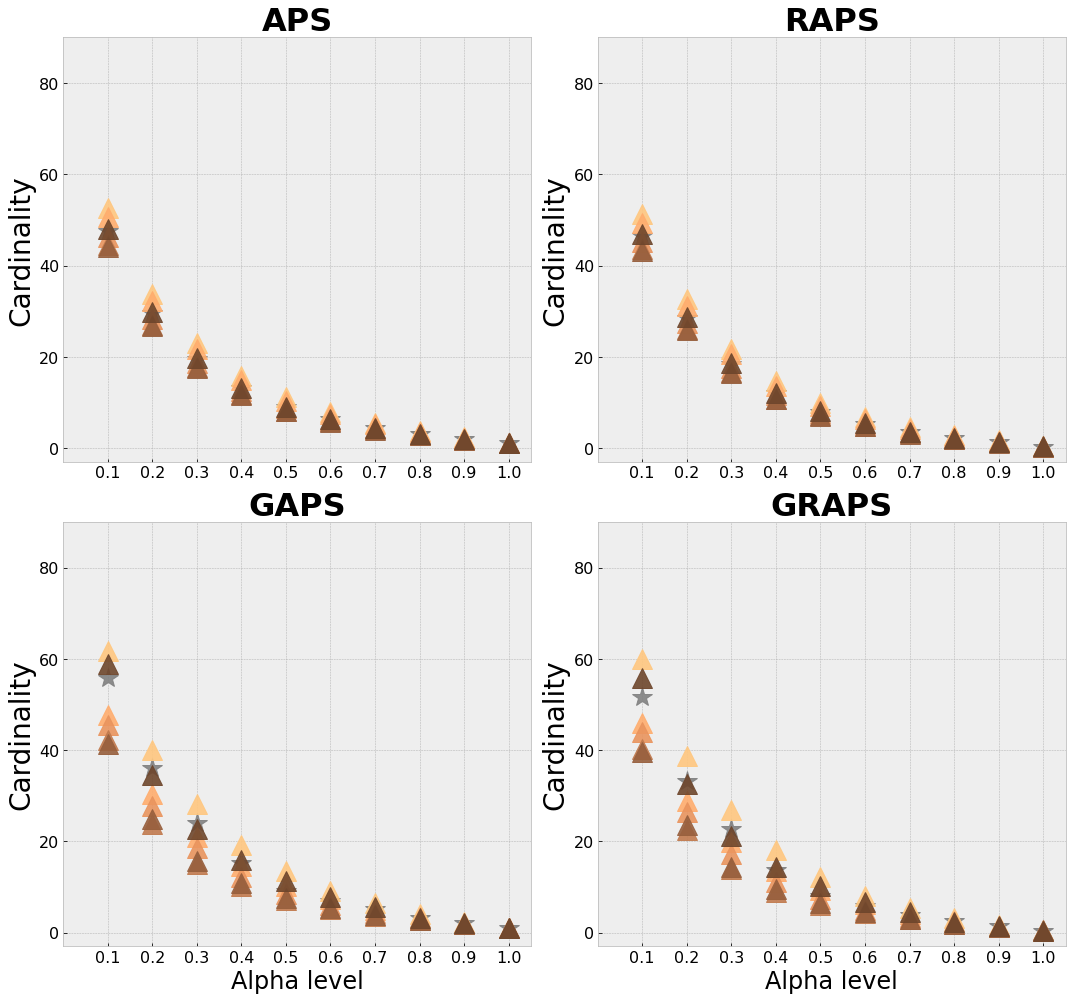

In [405]:
labelsize=16
ls=''
lw=6
marker = '^'
ms = 20
alpha=0.9
xticks = np.arange(0.1, 1.1, 0.1)
yticks = np.arange(0, 1.1, 0.1)
xlim = (0, 1.05)
ylim = (-3, 90)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 14), sharex=False, sharey=False)
# color = plt.cm.copper_r(np.linspace(0, 0.9, 7))

# for i, (k, v) in enumerate(naive_subgroup_cardinality_mean.items()):
#     ax[0, 0].plot(ALPHAS, v, label=f'{k}', ls=ls, lw=lw, marker=marker if i != 0 else '*', ms=ms, alpha=alpha, c=color[i] if i != 0 else 'darkgray')
# ax[0, 0].set_xlim(*xlim)
# ax[0, 0].set_title('NAIVE', fontsize=fontsize)
# ax[0, 0].set_ylabel('Cardinality', fontsize=fontsize)
# ax[0, 0].set_xticks(xticks)
# ax[0, 0].tick_params(axis='x', labelsize=labelsize)
# ax[0, 0].tick_params(axis='y', labelsize=labelsize)

# ax[0, 0].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[0, 0].text(0.08, 71, '95% confidence level', rotation=0, fontsize=fontsize)
# ax[1, 0].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[1, 0].text(0.08, 72, '95% confidence level', rotation=0, fontsize=fontsize)
# ax[0, 1].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[0, 1].text(0.08, 71, '95% confidence level', rotation=0, fontsize=fontsize)
# ax[1, 1].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[1, 1].text(0.08, 71, '95% confidence level', rotation=0, fontsize=fontsize)

for i, (k, v) in enumerate(aps_subgroup_cardinality_mean.items()):
    ax[0, 0].plot(ALPHAS, v, label=f'{k}', ls=ls, lw=lw, marker=marker if i != 0 else '*', ms=ms, alpha=alpha, c=SKIN_COLORS[i-1] if i != 0 else 'gray')
ax[0, 0].set_xlim(*xlim)
ax[0, 0].set_ylim(*ylim)
ax[0, 0].set_title('APS', fontsize=fontsize + 4, fontweight='bold')
# ax[0, 0].set_xlabel('Alpha level', fontsize=fontsize-4)
ax[0, 0].set_ylabel('Cardinality', fontsize=fontsize)
ax[0, 0].set_xticks(xticks)
ax[0, 0].tick_params(axis='x', labelsize=labelsize)
ax[0, 0].tick_params(axis='y', labelsize=labelsize)

for i, (k, v) in enumerate(raps_subgroup_cardinality_mean.items()):
    ax[0, 1].plot(ALPHAS, v, label=f'{k}', ls=ls, lw=lw, marker=marker if i != 0 else '*', ms=ms, alpha=alpha, c=SKIN_COLORS[i-1] if i != 0 else 'gray')
ax[0, 1].set_xlim(*xlim)
ax[0, 1].set_ylim(*ylim)
ax[0, 1].set_title('RAPS', fontsize=fontsize + 4, fontweight='bold')
# ax[0, 1].set_xlabel('Alpha level', fontsize=fontsize-4)
ax[0, 1].set_ylabel('Cardinality', fontsize=fontsize)
ax[0, 1].set_xticks(xticks)
ax[0, 1].tick_params(axis='x', labelsize=labelsize)
ax[0, 1].tick_params(axis='y', labelsize=labelsize)

for i, (k, v) in enumerate(gaps_subgroup_cardinality_mean.items()):
    ax[1, 0].plot(ALPHAS, v, label=f'{k}', ls=ls, lw=lw, marker=marker if i != 0 else '*', ms=ms, alpha=alpha, c=SKIN_COLORS[i-1] if i != 0 else 'gray')
ax[1, 0].set_xlim(*xlim)
ax[1, 0].set_ylim(*ylim)
ax[1, 0].set_title('GAPS', fontsize=fontsize + 4, fontweight='bold')
ax[1, 0].set_xlabel('Alpha level', fontsize=fontsize-4)
ax[1, 0].set_ylabel('Cardinality', fontsize=fontsize)
ax[1, 0].set_xticks(xticks)
ax[1, 0].tick_params(axis='x', labelsize=labelsize)
ax[1, 0].tick_params(axis='y', labelsize=labelsize)

for i, (k, v) in enumerate(graps_subgroup_cardinality_mean.items()):
    ax[1, 1].plot(ALPHAS, v, label=f'{k}', ls=ls, lw=lw, marker=marker if i != 0 else '*', ms=ms, alpha=alpha, c=SKIN_COLORS[i-1] if i != 0 else 'gray')
ax[1, 1].set_xlim(*xlim)
ax[1, 1].set_ylim(*ylim)
ax[1, 1].set_title('GRAPS', fontsize=fontsize + 4, fontweight='bold')
ax[1, 1].set_xlabel('Alpha level', fontsize=fontsize-4)
ax[1, 1].set_ylabel('Cardinality', fontsize=fontsize)
ax[1, 1].set_xticks(xticks)
ax[1, 1].tick_params(axis='x', labelsize=labelsize)
ax[1, 1].tick_params(axis='y', labelsize=labelsize)

handles, labels = ax[0, 0].get_legend_handles_labels()

plt.tight_layout()
# plt.subplots_adjust(bottom=0.2)
# plt.legend(
#     handles,
#     labels,
#     title='Fitzpatrick Skin Type', 
#     title_fontproperties={
#         'style': 'normal',
#         'size': fontsize-4,
#     },
#     fontsize=fontsize-4,
#     bbox_to_anchor=(0.95, -0.10, -0.0, 0),
#     ncol=7,
# )


plt.tight_layout()
# plt.legend(fontsize=fontsize, bbox_to_anchor=(0.95, -0.12, 0, 0), ncol=7)
plt.savefig(fig_dir / 'fitz-subgroup-cardinality.png')
plt.show()

### Measure subgroup coverage / cardinaltiy disparity

In [58]:
def get_diff(res):
    diff = []
    for a, b in itertools.combinations(list(range(len(res))), 2):
        if a == b: continue
        diff.append(abs(res[a] - res[b]))
        # diff.append(np.square(res[a] - res[b]))
    return diff

In [59]:
coverage_disparity = {}
print('COVERAGE'.center(20, '='))
for a in ALPHAS:
    naive_sub_cov = collections.defaultdict(list)
    for k, df in test_dfs.items(): 
        for sub, cov in get_subgroup_coverage(df, pred_col=f'naive_{a}').items():
            naive_sub_cov[sub].append(cov)
    naive_sub_cov = dict(naive_sub_cov)

    aps_sub_cov = collections.defaultdict(list)
    for k, df in test_dfs.items(): 
        for sub, cov in get_subgroup_coverage(df, pred_col=f'aps_{a}').items():
            aps_sub_cov[sub].append(cov)
    aps_sub_cov = dict(aps_sub_cov)

    raps_sub_cov = collections.defaultdict(list)
    for k, df in test_dfs.items(): 
        for sub, cov in get_subgroup_coverage(df, pred_col=f'raps_{a}').items():
            raps_sub_cov[sub].append(cov)
    raps_sub_cov = dict(raps_sub_cov)

    gaps_sub_cov = collections.defaultdict(list)
    for k, df in test_dfs.items(): 
        for sub, cov in get_subgroup_coverage(df, pred_col=f'gaps_{a}').items():
            gaps_sub_cov[sub].append(cov)
    gaps_sub_cov = dict(gaps_sub_cov)
    
    graps_sub_cov = collections.defaultdict(list)
    for k, df in test_dfs.items(): 
        for sub, cov in get_subgroup_coverage(df, pred_col=f'graps_{a}').items():
            graps_sub_cov[sub].append(cov)
    graps_sub_cov = dict(graps_sub_cov)

    print('\nalpha:', a)
    g = lambda x: round(np.mean(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 5)
    h = lambda x: round(np.std(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 5)
    f = lambda x: (g(x), h(x))
    print('naive\t', f(naive_sub_cov))
    print('aps\t', f(aps_sub_cov))
    print('gaps\t', f(gaps_sub_cov))
    print('raps\t', f(raps_sub_cov))
    print('graps\t', f(graps_sub_cov))

    coverage_disparity[a] = {
        'naive': f(naive_sub_cov),
        'aps': f(aps_sub_cov),
        'gaps': f(gaps_sub_cov),
        'raps': f(raps_sub_cov),
        'graps': f(graps_sub_cov),
    }

======COVERAGE======

alpha: 0.1
naive	 (0.0228, 0.01448)
aps	 (0.02212, 0.01522)
gaps	 (0.02501, 0.01436)
raps	 (0.02283, 0.01519)
graps	 (0.02519, 0.01506)

alpha: 0.2
naive	 (0.03957, 0.02912)
aps	 (0.03128, 0.02656)
gaps	 (0.02785, 0.01825)
raps	 (0.03488, 0.02655)
graps	 (0.02822, 0.01828)

alpha: 0.3
naive	 (0.05772, 0.03634)
aps	 (0.04792, 0.03091)
gaps	 (0.03051, 0.02363)
raps	 (0.04731, 0.0313)
graps	 (0.03058, 0.02217)

alpha: 0.4
naive	 (0.07868, 0.05048)
aps	 (0.05979, 0.03847)
gaps	 (0.04509, 0.02844)
raps	 (0.05584, 0.03433)
graps	 (0.03887, 0.02584)

alpha: 0.5
naive	 (0.09047, 0.05403)
aps	 (0.06555, 0.04171)
gaps	 (0.05619, 0.0348)
raps	 (0.05816, 0.03681)
graps	 (0.04998, 0.03091)

alpha: 0.6
naive	 (0.09946, 0.05764)
aps	 (0.06386, 0.04014)
gaps	 (0.0525, 0.03085)
raps	 (0.05576, 0.03445)
graps	 (0.04157, 0.02433)

alpha: 0.7
naive	 (0.09042, 0.0538)
aps	 (0.06761, 0.0411)
gaps	 (0.05812, 0.03644)
raps	 (0.04619, 0.02843)
graps	 (0.04282, 0.02789)

alpha: 0.8
naive	 

In [60]:
cardinality_disparity = {}
print('CARDINALITY'.center(20, '='))
for a in ALPHAS:
    naive_sub_card = collections.defaultdict(list)
    for k, df in test_dfs.items(): 
        for sub, card in get_subgroup_cardinality(df, pred_col=f'naive_{a}').items():
            naive_sub_card[sub].append(card)
    naive_sub_card = dict(naive_sub_card)

    aps_sub_card = collections.defaultdict(list)
    for k, df in test_dfs.items(): 
        for sub, card in get_subgroup_cardinality(df, pred_col=f'aps_{a}').items():
            aps_sub_card[sub].append(card)
    aps_sub_card = dict(aps_sub_card)

    raps_sub_card = collections.defaultdict(list)
    for k, df in test_dfs.items(): 
        for sub, card in get_subgroup_cardinality(df, pred_col=f'raps_{a}').items():
            raps_sub_card[sub].append(card)
    raps_sub_card = dict(raps_sub_card)

    gaps_sub_card = collections.defaultdict(list)
    for k, df in test_dfs.items(): 
        for sub, card in get_subgroup_cardinality(df, pred_col=f'gaps_{a}').items():
            gaps_sub_card[sub].append(card)
    gaps_sub_card = dict(gaps_sub_card)
    
    graps_sub_card = collections.defaultdict(list)
    for k, df in test_dfs.items(): 
        for sub, card in get_subgroup_cardinality(df, pred_col=f'graps_{a}').items():
            graps_sub_card[sub].append(card)
    graps_sub_card = dict(graps_sub_card)

    print('\nalpha:', a)
    g = lambda x: round(np.mean(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 4)
    h = lambda x: round(np.std(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 4)
    f = lambda x: (g(x), h(x))
    print('naive\t', f(naive_sub_card))
    print('aps\t', f(aps_sub_card))
    print('gaps\t', f(gaps_sub_card))
    print('raps\t', f(raps_sub_card))
    print('graps\t', f(graps_sub_card))
   
    cardinality_disparity[a] = {
        'naive': f(naive_sub_card),
        'aps': f(aps_sub_card),
        'gaps': f(gaps_sub_card),
        'raps': f(raps_sub_card),
        'graps': f(graps_sub_card),
    }

====CARDINALITY=====

alpha: 0.1
naive	 (3.6204, 2.2487)
aps	 (3.7264, 2.2634)
gaps	 (9.9885, 6.0891)
raps	 (3.6101, 2.1956)
graps	 (9.5079, 5.6638)

alpha: 0.2
naive	 (2.2102, 1.3908)
aps	 (3.1219, 1.9358)
gaps	 (7.4472, 4.3111)
raps	 (3.0494, 1.8943)
graps	 (7.0744, 4.204)

alpha: 0.3
naive	 (1.187, 0.7813)
aps	 (2.4308, 1.5436)
gaps	 (5.7037, 3.352)
raps	 (2.3598, 1.5002)
graps	 (5.6165, 3.3493)

alpha: 0.4
naive	 (0.4746, 0.3192)
aps	 (1.8177, 1.1857)
gaps	 (3.8462, 2.3386)
raps	 (1.7287, 1.1353)
graps	 (3.7461, 2.3555)

alpha: 0.5
naive	 (0.071, 0.0413)
aps	 (1.3317, 0.894)
gaps	 (2.6717, 1.6476)
raps	 (1.2365, 0.8359)
graps	 (2.5881, 1.5816)

alpha: 0.6
naive	 (0.1559, 0.1218)
aps	 (0.9678, 0.668)
gaps	 (1.7004, 1.0372)
raps	 (0.8715, 0.617)
graps	 (1.6199, 1.0028)

alpha: 0.7
naive	 (0.1695, 0.1152)
aps	 (0.6586, 0.474)
gaps	 (1.1924, 0.7174)
raps	 (0.5833, 0.4107)
graps	 (1.0682, 0.6516)

alpha: 0.8
naive	 (0.1222, 0.0753)
aps	 (0.4223, 0.3064)
gaps	 (0.5293, 0.349)
raps	 (0.36

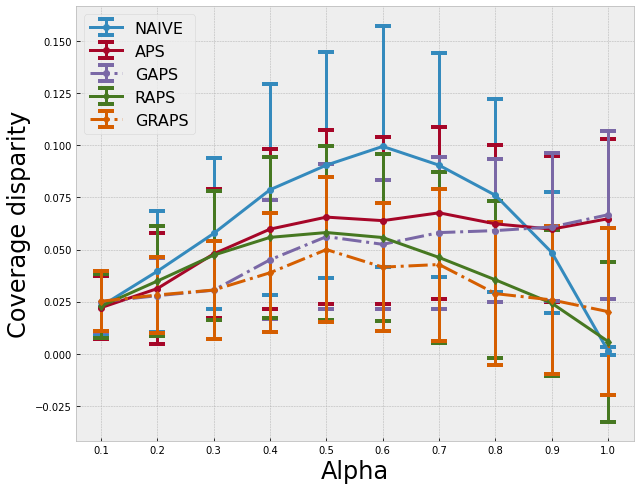

In [61]:
plt.figure(figsize=(10, 8))

plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Alpha', fontsize=24)
plt.ylabel('Coverage disparity', fontsize=24)

plt.errorbar(
    coverage_disparity.keys(),
    [x['naive'][0] for x in coverage_disparity.values()],
    yerr=[x['naive'][1] for x in coverage_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='NAIVE',
)
plt.errorbar(
    coverage_disparity.keys(),
    [x['aps'][0] for x in coverage_disparity.values()],
    yerr=[x['aps'][1] for x in coverage_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='APS',
)
plt.errorbar(
    coverage_disparity.keys(),
    [x['gaps'][0] for x in coverage_disparity.values()],
    yerr=[x['gaps'][1] for x in coverage_disparity.values()],
    marker='o',
    ls='-.',
    lw=3,
    capsize=8,
    capthick=4,
    label='GAPS',
)
plt.errorbar(
    coverage_disparity.keys(),
    [x['raps'][0] for x in coverage_disparity.values()],
    yerr=[x['aps'][1] for x in coverage_disparity.values()],
    marker='d',
    lw=3,
    capsize=8,
    capthick=4,
    label='RAPS',
)
plt.errorbar(
    coverage_disparity.keys(),
    [x['graps'][0] for x in coverage_disparity.values()],
    yerr=[x['gaps'][1] for x in coverage_disparity.values()],
    marker='d',
    ls='-.',
    lw=3,
    capsize=8,
    capthick=4,
    label='GRAPS',
)
plt.legend(fontsize=16)
plt.savefig(fig_dir / 'fitz-coverage-disparity.png')
plt.show()

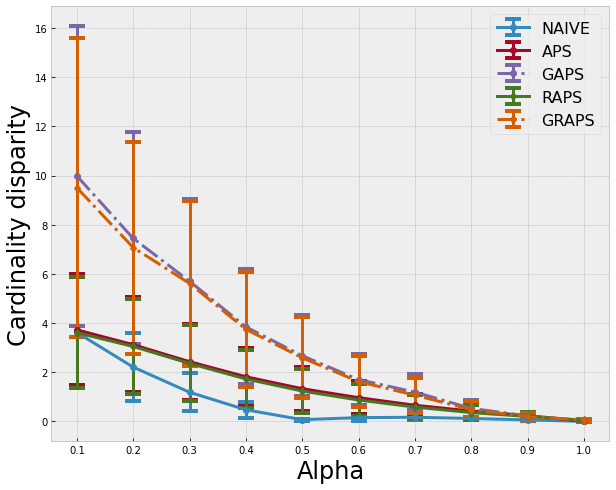

In [62]:
plt.figure(figsize=(10, 8))

plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Alpha', fontsize=24)
plt.ylabel('Cardinality disparity', fontsize=24)

plt.errorbar(
    cardinality_disparity.keys(),
    [x['naive'][0] for x in cardinality_disparity.values()],
    yerr=[x['naive'][1] for x in cardinality_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='NAIVE',
)
plt.errorbar(
    cardinality_disparity.keys(),
    [x['aps'][0] for x in cardinality_disparity.values()],
    yerr=[x['aps'][1] for x in cardinality_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='APS',
)
plt.errorbar(
    cardinality_disparity.keys(),
    [x['gaps'][0] for x in cardinality_disparity.values()],
    yerr=[x['gaps'][1] for x in cardinality_disparity.values()],
    marker='o',
    ls='-.',
    lw=3,
    capsize=8,
    capthick=4,
    label='GAPS',
)
plt.errorbar(
    cardinality_disparity.keys(),
    [x['raps'][0] for x in cardinality_disparity.values()],
    yerr=[x['aps'][1] for x in cardinality_disparity.values()],
    marker='d',
    lw=3,
    capsize=8,
    capthick=4,
    label='RAPS',
)
plt.errorbar(
    cardinality_disparity.keys(),
    [x['graps'][0] for x in cardinality_disparity.values()],
    yerr=[x['gaps'][1] for x in cardinality_disparity.values()],
    marker='d',
    ls='-.',
    lw=3,
    capsize=8,
    capthick=4,
    label='GRAPS',
)
plt.legend(fontsize=16)
plt.savefig(fig_dir / 'fitz-cardinality-disparity.png')
plt.show()

## Distribution of prediction set sizes by subgroup

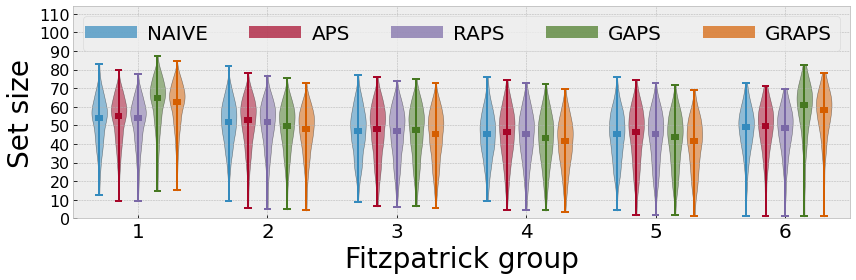

In [450]:
fontsize = 24
width = 0.12
alpha = 0.1
# alpha = 0.2

def set_box_color(bp, color):
    # plt.setp(bp['boxes'], color=color)
    plt.setp(bp['boxes'], facecolor=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color='k')
    
def set_violin_color(violin, color):
    for pc in violin['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.5)
        
    violin['cbars'].set_edgecolor(color)
    violin['cmaxes'].set_edgecolor(color)
    violin['cmins'].set_edgecolor(color)
    violin['cmedians'].set_edgecolor(color)
    violin['cmedians'].set_linewidth(6)
        
plt.figure(figsize=(12, 4))
# plt.title('Prediction set sizes by Fitzpatick subgroup', fontsize=fontsize)
plt.xticks(A[1:], fontsize=fontsize - 4)
plt.xlabel('Fitzpatrick group', fontsize=fontsize + 4)
plt.ylabel('Set size', fontsize=fontsize + 4)
plt.yticks(range(0, 120, 10), fontsize=fontsize - 8)
plt.xlim(0.5, 6.5)
plt.ylim(0, 114)

for i in range(1, len(A)):
    # box = plt.boxplot(
    violin = plt.violinplot(
        np.array([
            df[df.subgroup == i].apply(lambda x: len(x[f'naive_{alpha}']), axis=1)
            for df in test_dfs.values()
        ]).mean(0),
        positions=[i - 0.30],
        widths=width,
        showmedians=True,
        # notch=True,
        # meanline=False,
        # showcaps=False,
        # patch_artist=True,
    )
    # set_box_color(box, colors[i])
    # set_box_color(box, 'C0')
    set_violin_color(violin, 'C0')


for i in range(1, len(A)):
    # box = plt.boxplot(
    violin = plt.violinplot(
        np.array([
            df[df.subgroup == i].apply(lambda x: len(x[f'aps_{alpha}']), axis=1)
            for df in test_dfs.values()
        ]).mean(0),
        positions=[i - 0.15],
        widths=width,
        showmedians=True,
        # notch=True,
        # meanline=False,
        # showcaps=False,
        # patch_artist=True,
    )
    # set_box_color(box, colors[i])
    # set_box_color(box, 'C0')
    set_violin_color(violin, 'C1')

for i in range(1, len(A)):
    violin = plt.violinplot(
        np.array([
            df[df.subgroup == i].apply(lambda x: len(x[f'raps_{alpha}']), axis=1)
            for df in test_dfs.values()
        ]).mean(0),
        showmedians=True,
        positions=[i + 0.00],
        widths=width,
    )
    # set_box_color(box, colors[i])
    set_violin_color(violin, 'C2')
        
for i in range(1, len(A)):
    # box = plt.boxplot(
    violin = plt.violinplot(
        np.array([
            df[df.subgroup == i].apply(lambda x: len(x[f'gaps_{alpha}']), axis=1)
            for df in test_dfs.values()
        ]).mean(0),
        positions=[i+0.15],
        widths=width,
        showmedians=True,
        
    )
    # set_box_color(box, colors[i])
    set_violin_color(violin, 'C3')
    
    
for i in range(1, len(A)):
    # box = plt.boxplot(
    violin = plt.violinplot(
        np.array([
            df[df.subgroup == i].apply(lambda x: len(x[f'graps_{alpha}']), axis=1)
            for df in test_dfs.values()
        ]).mean(0),
        positions=[i+0.30],
        widths=width,
        showmedians=True,
    )
    # set_box_color(box, colors[i])
    set_violin_color(violin, 'C4')


a, = plt.plot([0,0], [0, 0],'C0', lw=12, alpha=0.7)
b, = plt.plot([0,0], [0, 0],'C1', lw=12, alpha=0.7)
c, = plt.plot([0,0], [0,0],'C2', lw=12, alpha=0.7)
d, = plt.plot([0,0], [0, 0],'C3', lw=12, alpha=0.7)
e, = plt.plot([0,0], [0, 0],'C4', lw=12, alpha=0.7)

plt.legend(
    (a, b, c, d, e),
    ['NAIVE', 'APS', 'RAPS', 'GAPS', 'GRAPS'],
    fontsize=fontsize - 4, 
    # bbox_to_anchor=(1.0, 1.2, 1, 1), 
    ncol=5,
    mode='expand',
    loc='upper center'
)
plt.tight_layout()
plt.savefig(fig_dir / 'fitz-boxplot-set-sizes.png')
plt.show()

## Ruling in and ruling out critical conditions

In [64]:
malignant_conditions = {
    reversed_label_map[x]: x for x in 
    skin_df.query('three_partition_label == "malignant"').raw_label.unique().tolist()
}
malignant_conditions

{42: 'kaposi sarcoma',
 56: 'melanoma',
 5: 'actinic keratosis',
 8: 'basal cell carcinoma',
 9: 'basal cell carcinoma morpheiform',
 60: 'mycosis fungoides',
 103: 'superficial spreading melanoma ssm',
 98: 'squamous cell carcinoma',
 46: 'lentigo maligna',
 97: 'solid cystic basal cell carcinoma',
 55: 'malignant melanoma'}

In [67]:
def rule_in(df, pred='aps_0.05', malignant_conditions=malignant_conditions.keys()):
    correct = 0
    total = 0

    for i, row in df.iterrows():
        if row['label'] in malignant_conditions:
            total += 1
            if row['label'] in row[pred]:
                correct += 1
    
    return correct / total

def rule_out(df, pred='aps_0.05'):
    correct = 0
    total = 0
    for i, row in df.iterrows():
        if row['label'] not in malignant_conditions:
            total += 1
            if len(set(row[pred]) & set(malignant_conditions)) == 0:
                correct += 1
                
    return correct / total

In [68]:
naive_rule_in = collections.defaultdict(list)
aps_rule_in = collections.defaultdict(list)
gaps_rule_in = collections.defaultdict(list)
raps_rule_in = collections.defaultdict(list)
graps_rule_in = collections.defaultdict(list)

naive_rule_out = collections.defaultdict(list)
aps_rule_out = collections.defaultdict(list)
gaps_rule_out = collections.defaultdict(list)
raps_rule_out = collections.defaultdict(list)
graps_rule_out = collections.defaultdict(list)

naive_crit_set_size = collections.defaultdict(list)
aps_crit_set_size = collections.defaultdict(list)
gaps_crit_set_size = collections.defaultdict(list)
raps_crit_set_size = collections.defaultdict(list)
graps_crit_set_size = collections.defaultdict(list)

naive_non_crit_set_size = collections.defaultdict(list)
aps_non_crit_set_size = collections.defaultdict(list)
gaps_non_crit_set_size = collections.defaultdict(list)
raps_non_crit_set_size = collections.defaultdict(list)
graps_non_crit_set_size = collections.defaultdict(list)

for alpha in ALPHAS:
    for seed in range(5):
        df = test_dfs[f'seed_{seed}']
        crit_df = df[df.label.isin(malignant_conditions)]
        non_crit_df = df[~df.label.isin(malignant_conditions)]
        
        naive_rule_in[alpha].append(rule_in(crit_df, f'naive_{alpha}'))
        aps_rule_in[alpha].append(rule_in(crit_df, f'aps_{alpha}'))
        gaps_rule_in[alpha].append(rule_in(crit_df, f'gaps_{alpha}'))
        raps_rule_in[alpha].append(rule_in(crit_df, f'raps_{alpha}'))
        graps_rule_in[alpha].append(rule_in(crit_df, f'graps_{alpha}'))
        
        naive_crit_set_size[alpha].append(crit_df[f'naive_{alpha}'].apply(len).mean())
        aps_crit_set_size[alpha].append(crit_df[f'aps_{alpha}'].apply(len).mean())
        gaps_crit_set_size[alpha].append(crit_df[f'gaps_{alpha}'].apply(len).mean())
        raps_crit_set_size[alpha].append(crit_df[f'raps_{alpha}'].apply(len).mean())
        graps_crit_set_size[alpha].append(crit_df[f'graps_{alpha}'].apply(len).mean())

        naive_rule_out[alpha].append(rule_out(non_crit_df, f'naive_{alpha}'))
        aps_rule_out[alpha].append(rule_out(non_crit_df, f'aps_{alpha}'))
        gaps_rule_out[alpha].append(rule_out(non_crit_df, f'gaps_{alpha}'))
        raps_rule_out[alpha].append(rule_out(non_crit_df, f'raps_{alpha}'))
        graps_rule_out[alpha].append(rule_out(non_crit_df, f'graps_{alpha}'))
        
        naive_non_crit_set_size[alpha].append(non_crit_df[f'naive_{alpha}'].apply(len).mean())
        aps_non_crit_set_size[alpha].append(non_crit_df[f'aps_{alpha}'].apply(len).mean())
        gaps_non_crit_set_size[alpha].append(non_crit_df[f'gaps_{alpha}'].apply(len).mean())
        raps_non_crit_set_size[alpha].append(non_crit_df[f'raps_{alpha}'].apply(len).mean())
        graps_non_crit_set_size[alpha].append(non_crit_df[f'graps_{alpha}'].apply(len).mean())

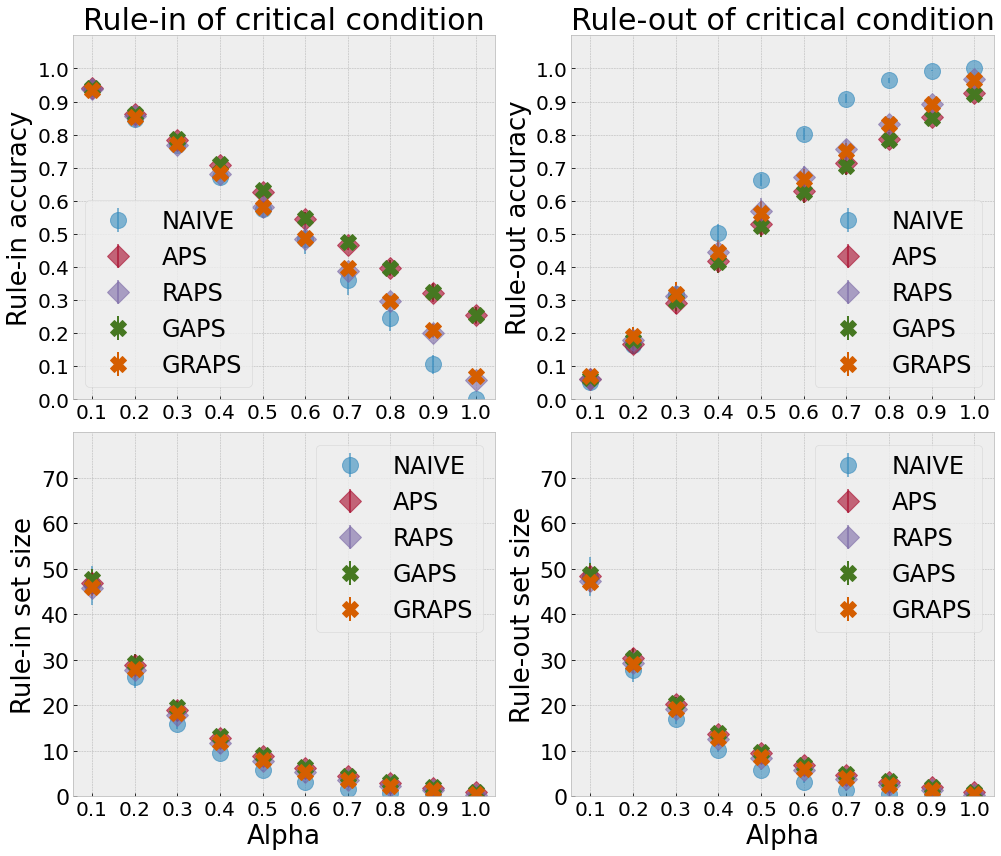

In [260]:
markersize=16
fontsize=26
alpha=0.8
fmt1='o'
fmt2='X'
fmt3='D'

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(14, 12)

ax[0, 0].set_title('Rule-in of critical condition', fontsize=fontsize + 4)
# ax[0, 0].set_xlabel('Alpha', fontsize=fontsize)
ax[0, 0].set_ylabel('Rule-in accuracy', fontsize=fontsize)
ax[0, 0].set_xticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[0, 0].set_yticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[0, 0].set_xticklabels([round(x, 1) for x in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[0, 0].set_yticklabels([round(y, 1) for y in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[0, 0].set_ylim(0, 1.1)

ax[0, 1].set_title('Rule-out of critical condition', fontsize=fontsize + 4)
# ax[0, 1].set_xlabel('Alpha', fontsize=fontsize)
ax[0, 1].set_ylabel('Rule-out accuracy', fontsize=fontsize)
ax[0, 1].set_xticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[0, 1].set_yticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[0, 1].set_xticklabels([round(x, 1) for x in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[0, 1].set_yticklabels([round(y, 1) for y in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[0, 1].set_ylim(0, 1.1)

# ax[1, 0].set_title('Rule-in', fontsize=fontsize + 4)
ax[1, 0].set_xlabel('Alpha', fontsize=fontsize)
ax[1, 0].set_ylabel('Rule-in set size', fontsize=fontsize)
ax[1, 0].set_xticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[1, 0].set_yticks(range(0, 80, 10), fontsize=fontsize)
ax[1, 0].set_xticklabels([round(x, 1) for x in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[1, 0].set_yticklabels(range(0, 80, 10), fontsize=fontsize-4)
ax[1, 0].set_ylim(0, 80)

# ax[1, 1].set_title('Rule-out', fontsize=fontsize + 4)
ax[1, 1].set_xlabel('Alpha', fontsize=fontsize)
ax[1, 1].set_ylabel('Rule-out set size', fontsize=fontsize)
ax[1, 1].set_xticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[1, 1].set_yticks(range(0, 80, 10), fontsize=fontsize)
ax[1, 1].set_xticklabels([round(x, 1) for x in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[1, 1].set_yticklabels(range(0, 80, 10), fontsize=fontsize-4)
ax[1, 1].set_ylim(0, 80)

# ax[0, 0].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[0, 1].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[1, 0].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[1, 1].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[0, 0].text(0.1, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
# ax[0, 1].text(0.1, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
# ax[1, 0].text(0.1, 65, '95% confidence level', rotation=0, fontsize=fontsize)
# ax[1, 1].text(0.1, 65, '95% confidence level', rotation=0, fontsize=fontsize)

naive = np.array(list(naive_rule_in.values()))
ax[0, 0].errorbar(
    ALPHAS, naive.mean(1), naive.std(1),
    fmt=fmt1, color='C0', markersize=markersize,
    label='NAIVE', alpha=alpha - 0.2,
)
aps = np.array(list(aps_rule_in.values()))
ax[0, 0].errorbar(
    ALPHAS, aps.mean(1), aps.std(1),
    fmt=fmt3, color='C1', markersize=markersize,
    label='APS', alpha=alpha - 0.2,
)
raps = np.array(list(raps_rule_in.values()))
ax[0, 0].errorbar(
    ALPHAS, raps.mean(1), raps.std(1),
    fmt=fmt3, color='C2', markersize=markersize,
    label='RAPS', alpha=alpha - 0.2,
)
gaps = np.array(list(gaps_rule_in.values()))
ax[0, 0].errorbar(
    ALPHAS, gaps.mean(1), gaps.std(1),
    fmt=fmt2, color='C3', markersize=markersize,
    label='GAPS', alpha=alpha + 0.2,
)
graps = np.array(list(graps_rule_in.values()))
ax[0, 0].errorbar(
    ALPHAS, graps.mean(1), graps.std(1),
    fmt=fmt2, color='C4', markersize=markersize,
    label='GRAPS', alpha=alpha + 0.2,
)
ax[0, 0].legend(fontsize=fontsize-2, loc='lower left')

naive = np.array(list(naive_rule_out.values()))
ax[0, 1].errorbar(
    ALPHAS, naive.mean(1), naive.std(1),
    fmt=fmt1, color='C0', markersize=markersize,
    label='NAIVE', alpha=alpha - 0.2,
)
aps = np.array(list(aps_rule_out.values()))
ax[0, 1].errorbar(
    ALPHAS, aps.mean(1), aps.std(1),
    fmt=fmt3, color='C1', markersize=markersize,
    label='APS', alpha=alpha - 0.2,
)
raps = np.array(list(raps_rule_out.values()))
ax[0, 1].errorbar(
    ALPHAS, raps.mean(1), raps.std(1),
    fmt=fmt3, color='C2', markersize=markersize,
    label='RAPS', alpha=alpha - 0.2,
)
gaps = np.array(list(gaps_rule_out.values()))
ax[0, 1].errorbar(
    ALPHAS, gaps.mean(1), gaps.std(1),
    fmt=fmt2, color='C3', markersize=markersize,
    label='GAPS', alpha=alpha + 0.2,
)
graps = np.array(list(graps_rule_out.values()))
ax[0, 1].errorbar(
    ALPHAS, graps.mean(1), graps.std(1),
    fmt=fmt2, color='C4', markersize=markersize,
    label='GRAPS', alpha=alpha + 0.2,
)
ax[0, 1].legend(fontsize=fontsize-2, loc='lower right')

naive = np.array(list(naive_crit_set_size.values()))
ax[1, 0].errorbar(
    ALPHAS, naive.mean(1), naive.std(1),
    fmt=fmt1, color='C0', markersize=markersize,
    label='NAIVE', alpha=alpha - 0.2,
)
aps = np.array(list(aps_crit_set_size.values()))
ax[1, 0].errorbar(
    ALPHAS, aps.mean(1), aps.std(1),
    fmt=fmt3, color='C1', markersize=markersize,
    label='APS', alpha=alpha - 0.2,
)
raps = np.array(list(raps_crit_set_size.values()))
ax[1, 0].errorbar(
    ALPHAS, raps.mean(1), raps.std(1),
    fmt=fmt3, color='C2', markersize=markersize,
    label='RAPS', alpha=alpha - 0.2,
)
gaps = np.array(list(gaps_crit_set_size.values()))
ax[1, 0].errorbar(
    ALPHAS, gaps.mean(1), gaps.std(1),
    fmt=fmt2, color='C3', markersize=markersize,
    label='GAPS', alpha=alpha + 0.2,
)
graps = np.array(list(graps_crit_set_size.values()))
ax[1, 0].errorbar(
    ALPHAS, graps.mean(1), graps.std(1),
    fmt=fmt2, color='C4', markersize=markersize,
    label='GRAPS', alpha=alpha + 0.2,
)
ax[1, 0].legend(fontsize=fontsize-2, loc='upper right')

naive = np.array(list(naive_non_crit_set_size.values()))
ax[1, 1].errorbar(
    ALPHAS, naive.mean(1), naive.std(1),
    fmt=fmt1, color='C0', markersize=markersize,
    label='NAIVE', alpha=alpha - 0.2,
)
aps = np.array(list(aps_non_crit_set_size.values()))
ax[1, 1].errorbar(
    ALPHAS, aps.mean(1), aps.std(1),
    fmt=fmt3, color='C1', markersize=markersize,
    label='APS', alpha=alpha - 0.2,
)
raps = np.array(list(raps_non_crit_set_size.values()))
ax[1, 1].errorbar(
    ALPHAS, raps.mean(1), raps.std(1),
    fmt=fmt3, color='C2', markersize=markersize,
    label='RAPS', alpha=alpha - 0.2,
)
gaps = np.array(list(gaps_non_crit_set_size.values()))
ax[1, 1].errorbar(
    ALPHAS, gaps.mean(1), gaps.std(1),
    fmt=fmt2, color='C3', markersize=markersize,
    label='GAPS', alpha=alpha + 0.2,
)
graps = np.array(list(graps_non_crit_set_size.values()))
ax[1, 1].errorbar(
    ALPHAS, graps.mean(1), graps.std(1),
    fmt=fmt2, color='C4', markersize=markersize,
    label='GRAPS', alpha=alpha + 0.2,
)
ax[1, 1].legend(fontsize=fontsize -2, loc='upper right')

plt.tight_layout()
plt.savefig(fig_dir / 'fitz-use-case-perf')
plt.show()

## Comparing rule-in/out between subgroups at $\alpha = 0.1$

In [70]:
all_group_naive_rule_in = {}
all_group_aps_rule_in = {}
all_group_gaps_rule_in = {}
all_group_raps_rule_in = {}
all_group_graps_rule_in = {}

all_group_naive_rule_out = {}
all_group_aps_rule_out = {}
all_group_gaps_rule_out = {}
all_group_raps_rule_out = {}
all_group_graps_rule_out = {}

all_group_naive_crit_set_size = {}
all_group_aps_crit_set_size = {}
all_group_gaps_crit_set_size = {}
all_group_raps_crit_set_size = {}
all_group_graps_crit_set_size = {}

all_group_naive_non_crit_set_size = {}
all_group_aps_non_crit_set_size = {}
all_group_gaps_non_crit_set_size = {}
all_group_raps_non_crit_set_size = {}
all_group_graps_non_crit_set_size = {}

for a in A:
    group_naive_rule_in = collections.defaultdict(list)
    group_aps_rule_in = collections.defaultdict(list)
    group_gaps_rule_in = collections.defaultdict(list)
    group_raps_rule_in = collections.defaultdict(list)
    group_graps_rule_in = collections.defaultdict(list)

    group_naive_rule_out = collections.defaultdict(list)
    group_aps_rule_out = collections.defaultdict(list)
    group_gaps_rule_out = collections.defaultdict(list)
    group_raps_rule_out = collections.defaultdict(list)
    group_graps_rule_out = collections.defaultdict(list)

    group_naive_crit_set_size = collections.defaultdict(list)
    group_aps_crit_set_size = collections.defaultdict(list)
    group_gaps_crit_set_size = collections.defaultdict(list)
    group_raps_crit_set_size = collections.defaultdict(list)
    group_graps_crit_set_size = collections.defaultdict(list)

    group_naive_non_crit_set_size = collections.defaultdict(list)
    group_aps_non_crit_set_size = collections.defaultdict(list)
    group_gaps_non_crit_set_size = collections.defaultdict(list)
    group_raps_non_crit_set_size = collections.defaultdict(list)
    group_graps_non_crit_set_size = collections.defaultdict(list)

    for alpha in ALPHAS:
        for seed in range(5):
            df = test_dfs[f'seed_{seed}']
            sub_df = df.query('subgroup == @a')
            crit_df = sub_df[sub_df.label.isin(malignant_conditions)]
            non_crit_df = sub_df[~sub_df.label.isin(malignant_conditions)]

            group_naive_rule_in[alpha].append(rule_in(crit_df, f'naive_{alpha}'))
            group_aps_rule_in[alpha].append(rule_in(crit_df, f'aps_{alpha}'))
            group_gaps_rule_in[alpha].append(rule_in(crit_df, f'gaps_{alpha}'))
            group_raps_rule_in[alpha].append(rule_in(crit_df, f'raps_{alpha}'))
            group_graps_rule_in[alpha].append(rule_in(crit_df, f'graps_{alpha}'))

            group_naive_crit_set_size[alpha].append(crit_df[f'naive_{alpha}'].apply(len).mean())
            group_aps_crit_set_size[alpha].append(crit_df[f'aps_{alpha}'].apply(len).mean())
            group_gaps_crit_set_size[alpha].append(crit_df[f'gaps_{alpha}'].apply(len).mean())
            group_raps_crit_set_size[alpha].append(crit_df[f'raps_{alpha}'].apply(len).mean())
            group_graps_crit_set_size[alpha].append(crit_df[f'graps_{alpha}'].apply(len).mean())

            group_naive_rule_out[alpha].append(rule_out(non_crit_df, f'naive_{alpha}'))
            group_aps_rule_out[alpha].append(rule_out(non_crit_df, f'aps_{alpha}'))
            group_gaps_rule_out[alpha].append(rule_out(non_crit_df, f'gaps_{alpha}'))
            group_raps_rule_out[alpha].append(rule_out(non_crit_df, f'raps_{alpha}'))
            group_graps_rule_out[alpha].append(rule_out(non_crit_df, f'graps_{alpha}'))

            group_naive_non_crit_set_size[alpha].append(non_crit_df[f'naive_{alpha}'].apply(len).mean())
            group_aps_non_crit_set_size[alpha].append(non_crit_df[f'aps_{alpha}'].apply(len).mean())
            group_gaps_non_crit_set_size[alpha].append(non_crit_df[f'gaps_{alpha}'].apply(len).mean())
            group_raps_non_crit_set_size[alpha].append(non_crit_df[f'raps_{alpha}'].apply(len).mean())
            group_graps_non_crit_set_size[alpha].append(non_crit_df[f'graps_{alpha}'].apply(len).mean())
            
    all_group_naive_rule_in[a] = group_naive_rule_in
    all_group_aps_rule_in[a] = group_aps_rule_in
    all_group_gaps_rule_in[a] = group_gaps_rule_in
    all_group_raps_rule_in[a] = group_raps_rule_in
    all_group_graps_rule_in[a] = group_graps_rule_in
    
    all_group_naive_rule_out[a] = group_naive_rule_out
    all_group_aps_rule_out[a] = group_aps_rule_out
    all_group_gaps_rule_out[a] = group_gaps_rule_out
    all_group_raps_rule_out[a] = group_raps_rule_out
    all_group_graps_rule_out[a] = group_graps_rule_out
    
    all_group_naive_crit_set_size[a] = group_naive_crit_set_size
    all_group_aps_crit_set_size[a] = group_aps_crit_set_size
    all_group_gaps_crit_set_size[a] = group_gaps_crit_set_size
    all_group_raps_crit_set_size[a] = group_raps_crit_set_size
    all_group_graps_crit_set_size[a] = group_graps_crit_set_size
    
    all_group_naive_non_crit_set_size[a] = group_naive_non_crit_set_size
    all_group_aps_non_crit_set_size[a] = group_aps_non_crit_set_size
    all_group_gaps_non_crit_set_size[a] = group_gaps_non_crit_set_size
    all_group_raps_non_crit_set_size[a] = group_raps_non_crit_set_size
    all_group_graps_non_crit_set_size[a] = group_graps_non_crit_set_size

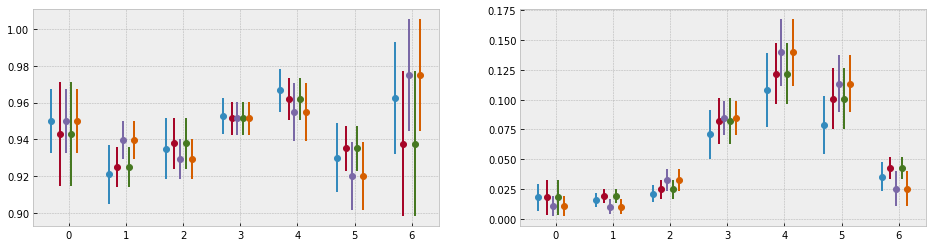

In [71]:
alpha = 0.1
# plt.ylim(0.5, 1)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 4)

ax[0].errorbar(
    x=[x-0.30 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_naive_rule_in.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_naive_rule_in.values()],
    marker='o',
    ls='',
)
ax[0].errorbar(
    x=[x-0.15 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_aps_rule_in.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_aps_rule_in.values()],
    marker='o',
    ls='',
)
ax[0].errorbar(
    x=[x-0.05 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_gaps_rule_in.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_gaps_rule_in.values()],
    marker='o',
    ls='',
)
ax[0].errorbar(
    x=[x+0.05 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_aps_rule_in.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_aps_rule_in.values()],
    marker='o',
    ls='',
)
ax[0].errorbar(
    x=[x+0.15 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_gaps_rule_in.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_gaps_rule_in.values()],
    marker='o',
    ls='',
)

ax[1].errorbar(
    x=[x-0.30 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_naive_rule_out.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_naive_rule_out.values()],
    marker='o',
    ls='',
)
ax[1].errorbar(
    x=[x-0.15 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_aps_rule_out.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_aps_rule_out.values()],
    marker='o',
    ls='',
)
ax[1].errorbar(
    x=[x-0.05 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_gaps_rule_out.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_gaps_rule_out.values()],
    marker='o',
    ls='',
)
ax[1].errorbar(
    x=[x+0.05 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_aps_rule_out.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_aps_rule_out.values()],
    marker='o',
    ls='',
)
ax[1].errorbar(
    x=[x+0.15 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_gaps_rule_out.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_gaps_rule_out.values()],
    marker='o',
    ls='',
)
plt.show()

## Comparing conformal uncertainty to epistemic uncertainty 

In [72]:
for _, df in test_dfs.items():
    res = []
    for i, row in df[[f'pred_{i}' for i in range(C)]].iterrows():
        res.append(torch.softmax(torch.tensor([
            getattr(row, f'pred_{i}') for i in range(C)
        ]), axis=0).numpy())
    df['mc_scores'] = res

In [73]:
for _, df in test_dfs.items():
    df['naive'] = df.mc_scores.apply(lambda x: 1 - x[:, 0].max())
    df['variance'] = df.mc_scores.apply(lambda x: np.mean(np.var(x, 1)))
    df['entropy'] = df.mc_scores.apply(lambda x: -np.mean(np.mean(x, 1) * np.log(np.mean(x, 1))))

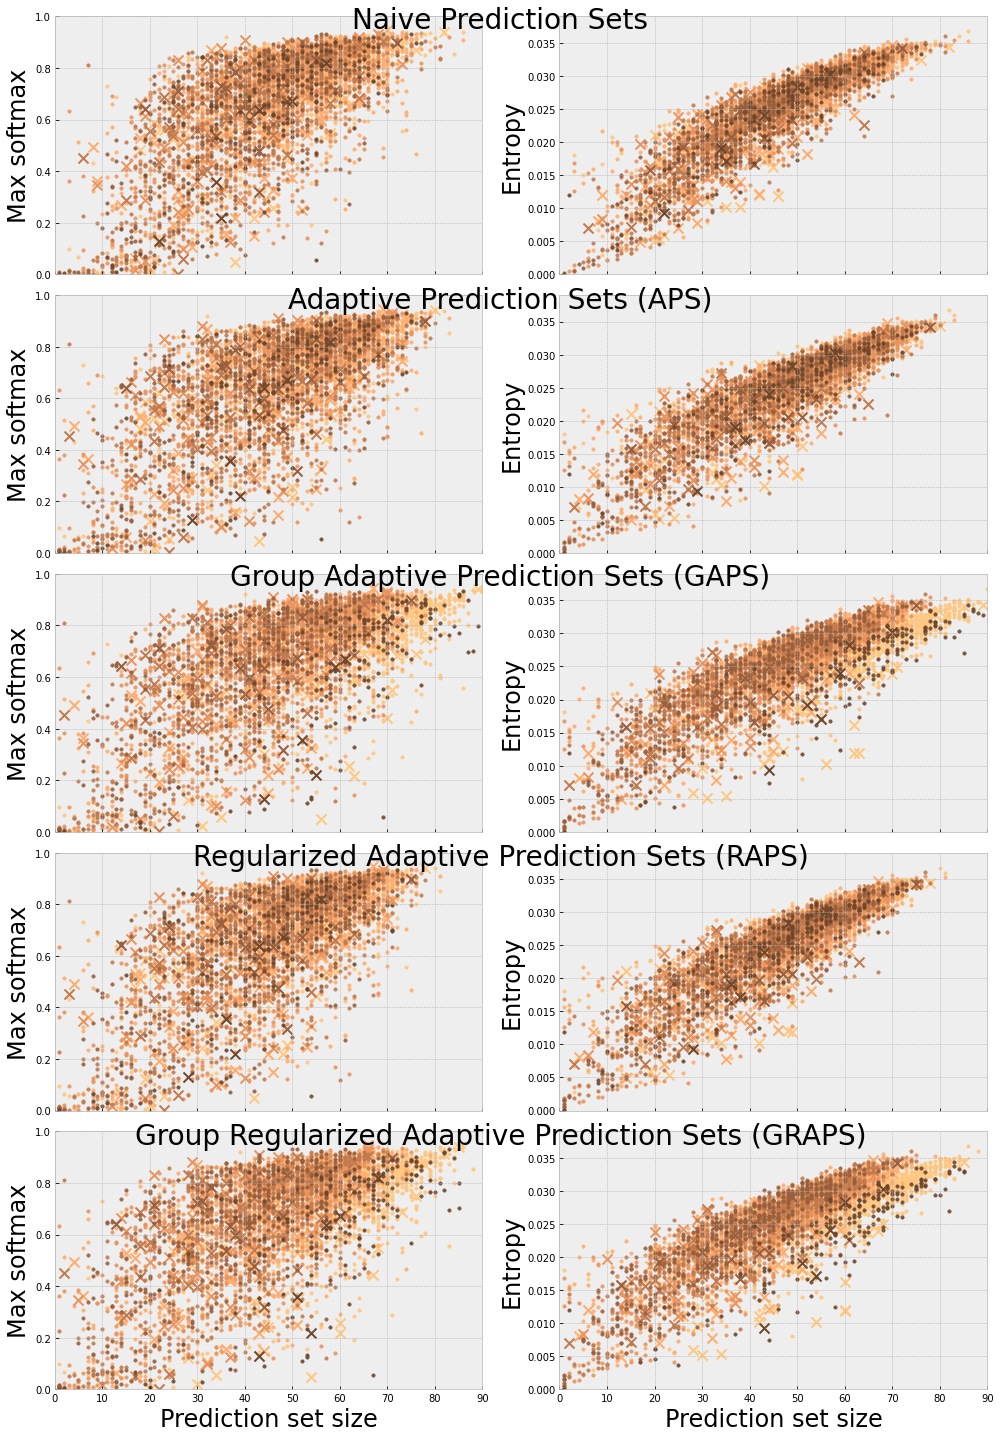

In [313]:
fontsize=24
alpha = 0.9
pos_marker='x'
neg_marker='o'
pos_marker_size=100
neg_marker_size=12
lw=4
ls='--'
alpha_level = 0.1
threshold = 114

label_map = dict(sorted(zip(skin_df.label.unique(), itertools.count())))
malignant =[label_map[x] for x in skin_df[skin_df.three_partition_label == 'malignant'].label.unique()]
pos_df = df[df.label.isin(malignant)]
neg_df = df[~df.label.isin(malignant)]
# neg_df = df[~df.label.isin(malignant)].sample(frac=0.2)

# fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(22, 32), sharex=False)
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(14, 20), sharex=True)
    
for j, conf in enumerate([f'naive_{alpha_level}', f'aps_{alpha_level}', f'gaps_{alpha_level}', f'raps_{alpha_level}', f'graps_{alpha_level}']):
    # ax[j, 0].set_title(f'{conf.split("_")[0].upper()} at {1 - alpha_level:.0%} confidence', fontsize=fontsize)
    # ax[j, 1].set_title(f'{conf.split("_")[0].upper()} at {1-alpha_level:.0%} confidence', fontsize=fontsize)
    # ax[j, 2].set_title(f'{conf.split("_")[0].upper()} at {1-alpha_level:.0%} confidence', fontsize=fontsize)
    
    ax[j, 0].set_ylabel('Max softmax', fontsize=fontsize)
    ax[j, 1].set_ylabel('Entropy', fontsize=fontsize)
    # ax[j, 2].set_ylabel('Variance', fontsize=fontsize)
    
    if j == 4:
        ax[j, 0].set_xlabel('Prediction set size', fontsize=fontsize)
        ax[j, 1].set_xlabel('Prediction set size', fontsize=fontsize)
        # ax[j, 2].set_xlabel('Prediction set size', fontsize=fontsize)

    for i, a in enumerate(A):
        if i == 0: continue
        c = SKIN_COLORS[i-1][None]

        sub_pos_df = pos_df.query('subgroup == @a')
        set_sizes = sub_pos_df[conf].map(len)
        
        sub_pos_df = sub_pos_df[set_sizes <= threshold]
        x_pos = set_sizes[set_sizes <= threshold]

        naive_y_pos = sub_pos_df.naive.values
        var_y_pos = sub_pos_df.variance.values
        ent_y_pos = sub_pos_df.entropy.values

        ax[j, 0].set_xlim(0, 90)
        ax[j, 1].set_xlim(0, 90)
        
        ax[j, 0].set_ylim(0, 1)
        ax[j, 1].set_ylim(0, 0.039)
        
        ax[j, 0].scatter(x_pos, naive_y_pos, alpha=1, c=c, s=pos_marker_size, marker=pos_marker)
        ax[j, 1].scatter(x_pos, ent_y_pos, alpha=1, c=c, s=pos_marker_size, marker=pos_marker)
        # ax[j, 2].scatter(x_pos, var_y_pos, alpha=1, c=c, s=100, marker='x')
        
        # ax[j, 0].plot(np.unique(x_pos), np.poly1d(np.polyfit(x_pos, naive_y_pos, 1))(np.unique(x_pos)), 
                   # c=SKIN_COLORS[i-1], lw=lw, ls=ls)
        # ax[j, 1].plot(np.unique(x_pos), np.poly1d(np.polyfit(x_pos, ent_y_pos, 1))(np.unique(x_pos)), 
        #            c=SKIN_COLORS[i-1], lw=lw, ls=ls)
        # ax[j, 2].plot(np.unique(x_pos), np.poly1d(np.polyfit(x_pos, var_y_pos, 1))(np.unique(x_pos)), 
        #            c=SKIN_COLORS[i-1], lw=lw, ls=ls)

        sub_neg_df = neg_df.query('subgroup == @a')
        set_sizes = sub_neg_df[conf].map(len)
        
        sub_neg_df = sub_neg_df[set_sizes <= threshold]
        x_neg = set_sizes[set_sizes <= threshold]

        naive_y_neg = sub_neg_df.naive.values
        var_y_neg = sub_neg_df.variance.values
        ent_y_neg = sub_neg_df.entropy.values

        ax[j, 0].scatter(x_neg, naive_y_neg, alpha=alpha, c=c, s=neg_marker_size, marker=neg_marker)
        ax[j, 1].scatter(x_neg, ent_y_neg, alpha=alpha, c=c, s=neg_marker_size, marker=neg_marker)
        # ax[j, 2].scatter(x_neg, var_y_neg, alpha=alpha, c=c, marker='o')

    #     ax[j, 0].plot(np.unique(x_neg), np.poly1d(np.polyfit(x_neg, naive_y_neg, 1))(np.unique(x_neg)), 
    #                c=SKIN_COLORS[i-1], lw=lw, ls=ls)
    #     ax[j, 1].plot(np.unique(x_neg), np.poly1d(np.polyfit(x_neg, var_y_neg, 1))(np.unique(x_neg)), 
    #                c=SKIN_COLORS[i-1], lw=lw, ls=ls)

    #     ax[j, 2].plot(np.unique(x_neg), np.poly1d(np.polyfit(x_neg, ent_y_neg, 1))(np.unique(x_neg)), 
    #                c=SKIN_COLORS[i-1], lw=lw, ls=ls)

    # va="center", ha="center",
# plt.suptitle('Epistemic uncertainty vs conformal uncertainty', fontsize=32)
plt.figtext(0.5, 0.987, f'Naive Prediction Sets', fontsize=28, va='center', ha='center')
plt.figtext(0.5, 0.793, f'Adaptive Prediction Sets (APS)', fontsize=28, va='center', ha='center')
plt.figtext(0.5, 0.600, f'Group Adaptive Prediction Sets (GAPS)', fontsize=28, va='center', ha='center')
plt.figtext(0.5, 0.406, f'Regularized Adaptive Prediction Sets (RAPS)', fontsize=28, va='center', ha='center')
plt.figtext(0.5, 0.212, f'Group Regularized Adaptive Prediction Sets (GRAPS)', fontsize=28, va='center', ha='center')
plt.tight_layout()
plt.savefig(fig_dir / 'fitz-uncertainty-compare.png')
plt.show()

In [426]:
alpha = 0.1
# alpha = 0.2
# alpha = 0.3
# alpha = 0.4
# alpha = 0.5

sub_df = df.query('subgroup == 1')
sub_df = df.query('subgroup == 2')
sub_df = df.query('subgroup == 3')
sub_df = df.query('subgroup == 4')
sub_df = df.query('subgroup == 5')
sub_df = df.query('subgroup == 6')
sub_df = df

precision = 3
# method = 'pearson'
method = 'spearman'
print(method.center(40, '-'))
print(round(pd.concat([sub_df[f'naive_{alpha}'].map(len), sub_df.naive], axis=1).corr(method).values[0, 1], precision))
print(round(pd.concat([sub_df[f'aps_{alpha}'].map(len), sub_df.naive], axis=1).corr(method).values[0, 1], precision))
print(round(pd.concat([sub_df[f'raps_{alpha}'].map(len), sub_df.naive], axis=1).corr(method).values[0, 1], precision))
print(round(pd.concat([sub_df[f'gaps_{alpha}'].map(len), sub_df.naive], axis=1).corr(method).values[0, 1], precision))
print(round(pd.concat([sub_df[f'graps_{alpha}'].map(len), sub_df.naive], axis=1).corr(method).values[0, 1], precision))
print()
print(round(pd.concat([sub_df[f'naive_{alpha}'].map(len), sub_df.entropy], axis=1).corr(method).values[0, 1], precision))
print(round(pd.concat([sub_df[f'aps_{alpha}'].map(len), sub_df.entropy], axis=1).corr(method).values[0, 1], precision))
print(round(pd.concat([sub_df[f'raps_{alpha}'].map(len), sub_df.entropy], axis=1).corr(method).values[0, 1], precision))
print(round(pd.concat([sub_df[f'gaps_{alpha}'].map(len), sub_df.entropy], axis=1).corr(method).values[0, 1], precision))
print(round(pd.concat([sub_df[f'graps_{alpha}'].map(len), sub_df.entropy], axis=1).corr(method).values[0, 1], precision))



----------------spearman----------------
0.66
0.646
0.647
0.607
0.611

0.909
0.893
0.894
0.835
0.839


In [102]:
malignant_conditions

{42: 'kaposi sarcoma',
 56: 'melanoma',
 5: 'actinic keratosis',
 8: 'basal cell carcinoma',
 9: 'basal cell carcinoma morpheiform',
 60: 'mycosis fungoides',
 103: 'superficial spreading melanoma ssm',
 98: 'squamous cell carcinoma',
 46: 'lentigo maligna',
 97: 'solid cystic basal cell carcinoma',
 55: 'malignant melanoma'}

In [110]:
alpha = 0.2
for method in [f'naive_{alpha}', f'aps_{alpha}', f'gaps_{alpha}', f'raps_{alpha}', f'graps_{alpha}']:
    print(method.upper().center(40, '='))
    # for low, high in [(0, 10)]:
    for low, high in [(0, 15)]:
    # for low, high in [(0, 20)]:
    # for low, high in [(0, 30)]:
        print(low, high)
        conf_sets = df[(low <= df[method].map(len)) & (df[method].map(len) < high)]
        for a in A:
            if a == 0: continue
            print(str(a).center(30, '-'))
            sub_conf_sets = conf_sets.query('subgroup == @a and label in @malignant_conditions.keys()')
            count = sub_conf_sets.shape[0]
            if count == 0:
                print(a, f'SKIP {low=} {high=}')
                continue
            print(f'{count=}', end='\t')
            print(f'coverage: {sub_conf_sets.apply(lambda row: row.label in row[method], axis=1).sum() / len(sub_conf_sets):.2f}')
            print(f'size: {sub_conf_sets[method].map(len).mean():.1f}')
            print()

===============NAIVE_0.2================
0 15
--------------1---------------
count=20	coverage: 0.85
size: 11.0

--------------2---------------
count=22	coverage: 1.00
size: 9.8

--------------3---------------
count=35	coverage: 1.00
size: 11.4

--------------4---------------
count=13	coverage: 1.00
size: 10.8

--------------5---------------
count=5	coverage: 0.80
size: 12.2

--------------6---------------
count=3	coverage: 0.67
size: 11.0

================APS_0.2=================
0 15
--------------1---------------
count=25	coverage: 0.84
size: 9.1

--------------2---------------
count=33	coverage: 0.97
size: 8.2

--------------3---------------
count=46	coverage: 1.00
size: 9.1

--------------4---------------
count=16	coverage: 0.94
size: 8.9

--------------5---------------
count=7	coverage: 0.86
size: 10.3

--------------6---------------
count=4	coverage: 0.50
size: 10.5

================GAPS_0.2================
0 15
--------------1---------------
count=18	coverage: 0.83
size: 10.1



In [76]:
for method in ['naive_0.1', 'aps_0.1', 'gaps_0.1', 'raps_0.1', 'graps_0.1']:
    print(method.upper().center(40, '='))
    for low, high in [(0, 5), (5, 10), (10, 25), (25, 50), (50, 114)]:
        print(low, high)
        med_conf_sets = df[(low <= df[method].map(len)) & (df[method].map(len) < high)]
        for a in A:
            print(str(a).center(20, '-'))
            # sub_high_conf_sets = high_conf_sets.query('subgroup == @a')
            sub_med_conf_sets = med_conf_sets.query('subgroup == @a')
            count = sub_med_conf_sets.shape[0]
            if count == 0:
                print(a, f'SKIP {low=} {high=}')
                continue
            print(a, f'{count=}')
            # sub_low_conf_sets = low_conf_sets.query('subgroup == @a')
            # print(sub_high_conf_sets.shape, sub_low_conf_sets.shape)
            # print(f'high coverage: {sub_high_conf_sets.apply(lambda row: row.label in row[method], axis=1).sum() / len(sub_high_conf_sets):.2f}')
            print(f'coverage: {sub_med_conf_sets.apply(lambda row: row.label in row[method], axis=1).sum() / len(sub_med_conf_sets):.2f}')
            # print(f'low coverage: {sub_low_conf_sets.apply(lambda row: row.label in row[method], axis=1).sum() / len(sub_low_conf_sets):.2f}')
            # print(f'avg high size: {sub_high_conf_sets[method].map(len).mean():.2f}')
            print(f'size: {sub_med_conf_sets[method].map(len).mean():.1f}')
            # print(f'avg low size: {sub_low_conf_sets[method].map(len).mean():.2f}')


===============NAIVE_0.1================
0 5
---------0----------
0 SKIP low=0 high=5
---------1----------
1 count=1
coverage: 0.00
size: 3.0
---------2----------
2 count=1
coverage: 0.00
size: 3.0
---------3----------
3 count=5
coverage: 0.60
size: 2.8
---------4----------
4 SKIP low=0 high=5
---------5----------
5 count=3
coverage: 1.00
size: 2.7
---------6----------
6 count=2
coverage: 0.50
size: 1.5
5 10
---------0----------
0 SKIP low=5 high=10
---------1----------
1 count=5
coverage: 0.80
size: 8.0
---------2----------
2 count=7
coverage: 0.57
size: 7.6
---------3----------
3 count=7
coverage: 0.71
size: 7.0
---------4----------
4 count=11
coverage: 0.91
size: 7.3
---------5----------
5 count=3
coverage: 1.00
size: 6.3
---------6----------
6 SKIP low=5 high=10
10 25
---------0----------
0 count=12
coverage: 1.00
size: 18.4
---------1----------
1 count=38
coverage: 0.82
size: 19.8
---------2----------
2 count=82
coverage: 0.89
size: 18.0
---------3----------
3 count=105
coverage: 